In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns

from IPython.core.pylabtools import figsize

import numpy.random as r
from pylab import *
from matplotlib.gridspec import GridSpec

import sys
sys.path.insert(0, '../../utils')
import splicing_utils as spu
import single_cell_plots as scp
from single_cell_plots import *

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

mpl.rcParams["mathtext.fontset"] = "stix"


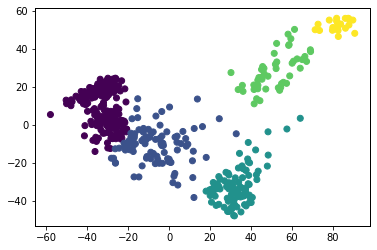

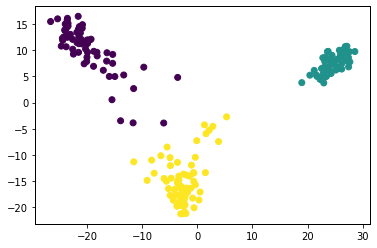

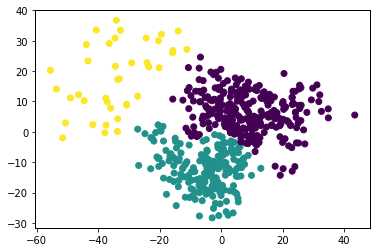

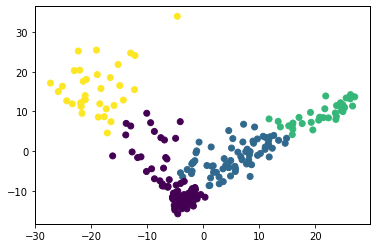

In [6]:
%run -i 'load_data.py'

In [7]:
# import importlib
# importlib.reload(scp)
# importlib.reload(spu)
# sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"

In [8]:
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import rpy2
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri as rpyn
from statsmodels.stats.multitest import multipletests
dt = rpy2.robjects.packages.importr('diptest')

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.special import logit
from scipy.special import expit

from sklearn.metrics import adjusted_rand_score

from scipy.stats import chisquare

In [9]:
chen_selected_exons = []
for clust in chen_clust_filter:
    chen_selected_exons.extend(list(clust[0].index))
    
chen_selected_exons = sorted(set(chen_selected_exons))

aver = filter_psi(chen_PSI.loc[chen_selected_exons], chen_selected_exons, mrna_per_event_chen, chen_coverage_tab['SJ_coverage'],
          chen_read_counts, 10, 0, 0)

aver_total_ = aver[0].T.corr().index
aver_total_ = aver_total_[aver[0].loc[aver_total_].T.corr().isna().mean(axis=1) <= 0.01]
#aver[0].loc[aver_total_]


aver_filtered_ = []
aver_filtered_basura_ = []
for x in aver_total_:
    if x.split('_')[:-1] not in aver_filtered_basura_:
        aver_filtered_.append(x)
        aver_filtered_basura_.append(x.split('_')[:-1])

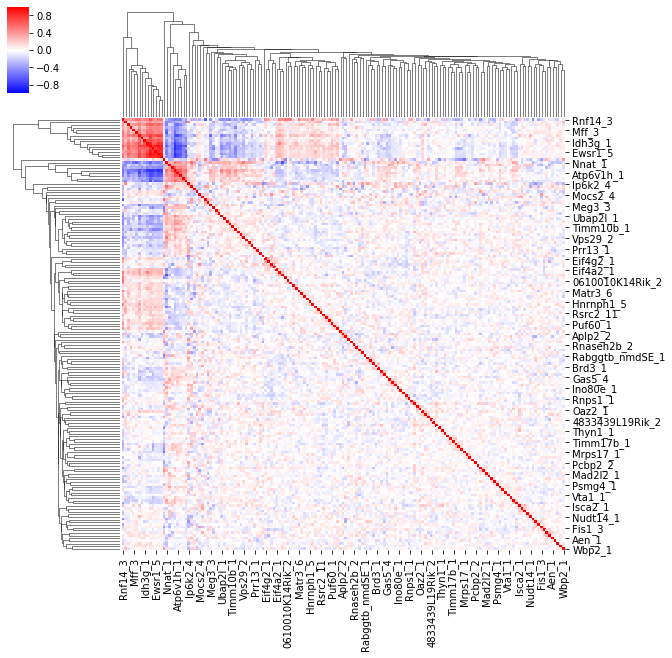

In [10]:
figsize(4,4)
sns.clustermap(aver[0].loc[aver_filtered_].T.corr(), cmap=cm.bwr, vmin=-1, vmax=1)
plt.show()

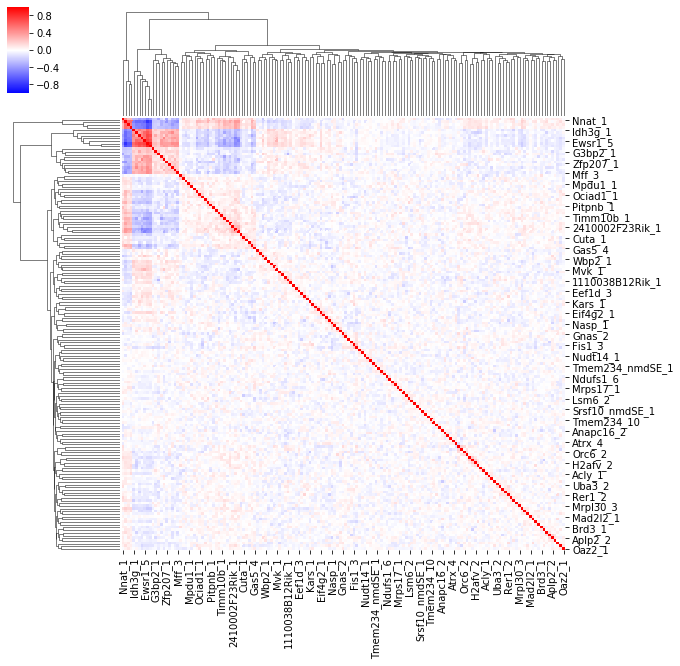

In [11]:
from scipy.stats import zscore
aver_finale = aver[0].loc[aver_filtered_]#
aver_finale = pd.DataFrame(zscore(aver_finale.T.fillna(aver_finale.T.mean()).T))
aver_finale.columns = aver[0].columns
aver_finale.index = aver_filtered_

sns.clustermap(aver_finale.loc[aver_filtered_].T.corr(), cmap=cm.bwr, vmin=-1, vmax=1)
plt.show()

In [12]:
# chen_MN_int_genes, chen_MN_int_exons = spu.get_int_events(chen_PSI[chen_MN], chen_mrna_counts[chen_MN], 0.2)

# aver = filter_psi(chen_PSI[chen_MN], chen_MN_int_exons, mrna_per_event_chen[chen_MN], 
#                   chen_coverage_tab.loc[chen_MN, 'SJ_coverage'],
#                   chen_read_counts[chen_MN], 10, 0, 0.5)

# aver_total_ = aver[0].T.corr().index
# aver_total_ = aver_total_[aver[0].loc[aver_total_].T.corr().isna().mean(axis=1) <= 0.01]
# #aver[0].loc[aver_total_]


# aver_filtered_ = []
# aver_filtered_basura_ = []
# for x in aver_total_:
#     if x.split('_')[:-1] not in aver_filtered_basura_:
#         aver_filtered_.append(x)
#         aver_filtered_basura_.append(x.split('_')[:-1])

In [13]:
# figsize(4,4)
# sns.clustermap(aver[0].loc[aver_filtered_].T.corr(), cmap=cm.bwr, vmin=-1, vmax=1)
# plt.show()

In [107]:
def cluster_chi_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True, 
                     print_extreme=False, extreme = 0.9):
    cluster_array = []
    pvals = []
    exon_pass = []
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi[1] >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
    if correct_multitest:
        pvals_adj = multipletests(pvals, method=correction)[1]
    else:
        pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals_adj


def cluster_fisher_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True, 
                     print_extreme=False, extreme = 0.9):
    cluster_array = []
    pvals = []
    exon_pass = []
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_fisher(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi_p >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
    if correct_multitest:
        pvals_adj = multipletests(pvals, method=correction)[1]
    else:
        pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals_adj
    
    
    
def test_exon_chi(PSI_tab, exon, clusters, psi_lim = 0.5):
    chi_pos = []
    chi_neg = []
    for clust in clusters.unique():
        cluster_cells = clusters.loc[clusters == clust].index
        
        pos_cases = (PSI_tab.loc[exon, cluster_cells] >= psi_lim).sum()
        missing = PSI_tab.loc[exon, cluster_cells].isna().sum()
        neg_cases = len(cluster_cells) - pos_cases - missing
        
        chi_pos.append(pos_cases)
        chi_neg.append(neg_cases)
        
#     print(chi_pos)
#     print(chi_neg)
        
    return chisquare(chi_pos, chi_neg), np.array(chi_pos), np.array(chi_neg)


def test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = 0.25):
    
    psi_mean = PSI_tab.loc[exon].mean()
    chi_pos = []
    chi_exp = []
    chi_neg = []
    for clust in clusters.unique():
        cluster_cells = clusters.loc[clusters == clust].index
        
        pos_cases = (PSI_tab.loc[exon, cluster_cells] >= (1-psi_lim)).sum()
        #missing = PSI_tab.loc[exon, cluster_cells].isna().sum()
        neg_cases = (PSI_tab.loc[exon, cluster_cells] <= psi_lim).sum()
        
        expected_pos = (pos_cases + neg_cases) * psi_mean
        
        
        chi_pos.append(pos_cases)
        chi_exp.append(expected_pos)
        chi_neg.append(neg_cases)
        
        
    return chisquare(chi_pos, chi_exp)[1], np.array(chi_pos), np.array(chi_neg), np.array(chi_exp)



def test_exon_bimodal_fisher(PSI_tab, exon, clusters, psi_lim = 0.25):
    
    psi_mean = PSI_tab.loc[exon].mean()
    chi_pos = []
    chi_exp = []
    chi_neg = []
    for clust in clusters.unique():
        cluster_cells = clusters.loc[clusters == clust].index
        
        pos_cases = (PSI_tab.loc[exon, cluster_cells] >= (1-psi_lim)).sum()
        #missing = PSI_tab.loc[exon, cluster_cells].isna().sum()
        neg_cases = (PSI_tab.loc[exon, cluster_cells] <= psi_lim).sum()
        
        expected_pos = (pos_cases + neg_cases) * psi_mean
        
        
        chi_pos.append(pos_cases)
        chi_exp.append(expected_pos)
        chi_neg.append(neg_cases)
        
    ftest_p = stats.fisher_test(np.array([chi_pos, chi_neg]))[0][0]
        
    return ftest_p, np.array(chi_pos), np.array(chi_neg), np.array(chi_exp)

In [15]:
# def test_exon_chi(PSI_tab, exon, clusters, psi_lim = 0.5):
#     chi_pos = []
#     chi_neg = []
#     for clust in clusters.unique():
#         cluster_cells = clusters.loc[clusters == clust].index
        
#         pos_cases = (PSI_tab.loc[exon, cluster_cells] >= psi_lim).sum()
#         missing = PSI_tab.loc[exon, cluster_cells].isna().sum()
#         neg_cases = len(cluster_cells) - pos_cases - missing
        
#         chi_pos.append(pos_cases)
#         chi_neg.append(neg_cases)
        
# #     print(chi_pos)
# #     print(chi_neg)
        
#     return chisquare(chi_pos, chi_neg), np.array(chi_pos), np.array(chi_neg)


# def test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = 0.25):
    
#     psi_mean = PSI_tab.loc[exon].mean()
#     chi_pos = []
#     chi_exp = []
#     chi_neg = []
#     for clust in clusters.unique():
#         cluster_cells = clusters.loc[clusters == clust].index
        
#         pos_cases = (PSI_tab.loc[exon, cluster_cells] >= (1-psi_lim)).sum()
#         #missing = PSI_tab.loc[exon, cluster_cells].isna().sum()
#         neg_cases = (PSI_tab.loc[exon, cluster_cells] <= psi_lim).sum()
        
#         expected_pos = (pos_cases + neg_cases) * psi_mean
        
        
#         chi_pos.append(pos_cases)
#         chi_exp.append(expected_pos)
#         chi_neg.append(neg_cases)
        
        
#     return chisquare(chi_pos, chi_exp), np.array(chi_pos), np.array(chi_neg), np.array(chi_exp)

In [16]:
from scipy.stats import hypergeom
def hyper_test(M, n, N, k):
    
    hpd = hypergeom(M, n, N)
    p_depleted = hpd.cdf(k)
    p_enriched = hpd.sf(k-1)
    
    return p_depleted, p_enriched

In [17]:
from scipy.stats import probplot

In [184]:
def test_chi_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
          read_counts, 0, read_min, obs_min)
    
    
    # Events that do not pass the filter
    
    change_tab_all, chi_p_all = cluster_chi_test(PSI_tab.loc[int_exons], clusters, psi_bin)
    
    unfiltered_exons = [x for x in int_exons if x not in aver[0].index]
    change_tab_uf, chi_p_uf = cluster_chi_test(PSI_tab.loc[unfiltered_exons], clusters, psi_bin)
    
    unfiltered_exons_r = [x for x in int_exons if x not in aver_reads[0].index]
    change_tab_ufr, chi_p_ufr = cluster_chi_test(PSI_tab.loc[unfiltered_exons_r], clusters, psi_bin)
    
    change_tab_aver, chi_p_aver = cluster_chi_test(aver[0], clusters, psi_bin)
    change_tab_nofilt, chi_p_nofilt = cluster_chi_test(PSI_tab.loc[aver[0].index], clusters, psi_bin)
    change_tab_averr, chi_p_averr = cluster_chi_test(aver_reads[0], clusters, psi_bin)

    figsize(8, 4)
    fig = plt.figure()
    fig.suptitle('adjusted p-values of $\chi^2$ test')

    gs = GridSpec(6,10)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])

    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
#     ax_marg_x5 = fig.add_subplot(gs[0:6,9])
    
    ax_joint.scatter(probplot(chi_p_aver)[0][0], probplot(chi_p_aver)[0][1], alpha = 0.75, c='navy', label='joint filter')
    ax_joint.scatter(probplot(chi_p_averr)[0][0], probplot(chi_p_averr)[0][1], alpha = 0.75, c='darkred', label='read filter')
    ax_joint.scatter(probplot(chi_p_all)[0][0], probplot(chi_p_all)[0][1], alpha = 0.75, c='forestgreen', label='all exons')
    ax_joint.scatter(probplot(chi_p_uf)[0][0], probplot(chi_p_uf)[0][1], alpha = 0.75, c='purple', label='rejected')
#     ax_joint.scatter(probplot(chi_p_ufr)[0][0], probplot(chi_p_ufr)[0][1], alpha = 0.2, c='darkorange')
    ax_joint.plot([-3, 3], [0.05, 0.05], 'r--')
    
    ax_marg_x1.hist(chi_p_aver, orientation="horizontal", color='navy')
    ax_marg_x2.hist(chi_p_averr, orientation="horizontal", color='darkred')
    ax_marg_x3.hist(chi_p_all, orientation="horizontal", color='forestgreen')
    ax_marg_x4.hist(chi_p_uf, orientation="horizontal", color='purple')
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
#     ax_marg_x5.hist(chi_p_ufr, orientation="horizontal", color='darkrorange')

    ax_joint.set_xlabel('adjusted p-value')
    ax_joint.set_ylabel('Normal theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    
def test_fisher_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10, print_extreme=False):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
          read_counts, 0, read_min, obs_min)
    
    
    # Events that do not pass the filter
    
    change_tab_all, chi_p_all = cluster_fisher_test(PSI_tab.loc[int_exons], clusters, psi_bin, print_extreme = print_extreme)
    
    unfiltered_exons = [x for x in int_exons if x not in aver[0].index]
    change_tab_uf, chi_p_uf = cluster_fisher_test(PSI_tab.loc[unfiltered_exons], clusters, psi_bin, 
                                                  print_extreme = print_extreme)
    
    unfiltered_exons_r = [x for x in int_exons if x not in aver_reads[0].index]
    change_tab_ufr, chi_p_ufr = cluster_fisher_test(PSI_tab.loc[unfiltered_exons_r], clusters, psi_bin,
                                                    print_extreme = print_extreme)
    
    change_tab_aver, chi_p_aver = cluster_fisher_test(aver[0], clusters, psi_bin)
    change_tab_nofilt, chi_p_nofilt = cluster_fisher_test(PSI_tab.loc[aver[0].index], clusters, psi_bin, 
                                                          print_extreme = print_extreme)
    change_tab_averr, chi_p_averr = cluster_fisher_test(aver_reads[0], clusters, psi_bin, print_extreme = print_extreme)

    figsize(8, 4)
    fig = plt.figure()
    fig.suptitle('adjusted p-values of Fisher test')

    gs = GridSpec(6,10)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])

    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
#     ax_marg_x5 = fig.add_subplot(gs[0:6,9])
    
    ax_joint.scatter(probplot(chi_p_aver)[0][0], probplot(chi_p_aver)[0][1], alpha = 0.75, c='navy', label='joint filter')
    ax_joint.scatter(probplot(chi_p_averr)[0][0], probplot(chi_p_averr)[0][1], alpha = 0.75, c='darkred', label='read filter')
    ax_joint.scatter(probplot(chi_p_all)[0][0], probplot(chi_p_all)[0][1], alpha = 0.75, c='forestgreen', label='all exons')
    ax_joint.scatter(probplot(chi_p_uf)[0][0], probplot(chi_p_uf)[0][1], alpha = 0.75, c='purple', label='rejected')
#     ax_joint.scatter(probplot(chi_p_ufr)[0][0], probplot(chi_p_ufr)[0][1], alpha = 0.2, c='darkorange')
    ax_joint.plot([-3, 3], [0.05, 0.05], 'r--')
    
    ax_marg_x1.hist(chi_p_aver, orientation="horizontal", color='navy')
    ax_marg_x2.hist(chi_p_averr, orientation="horizontal", color='darkred')
    ax_marg_x3.hist(chi_p_all, orientation="horizontal", color='forestgreen')
    ax_marg_x4.hist(chi_p_uf, orientation="horizontal", color='purple')
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
#     ax_marg_x5.hist(chi_p_ufr, orientation="horizontal", color='darkrorange')

    ax_joint.set_xlabel('adjusted p-value')
    ax_joint.set_ylabel('Normal theoratical quantiles')
    ax_joint.legend(frameon=False)
    
    plt.show()

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


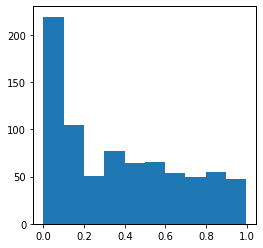

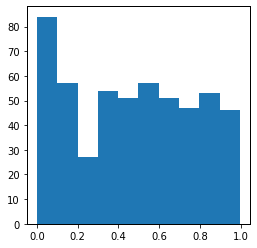

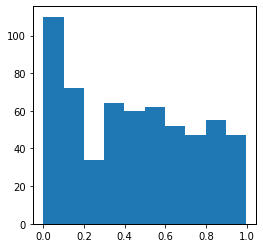

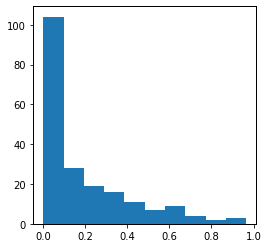

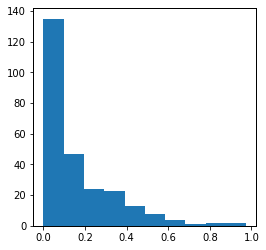

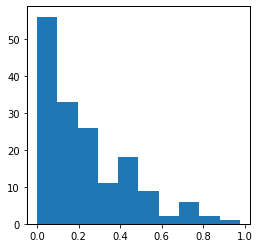

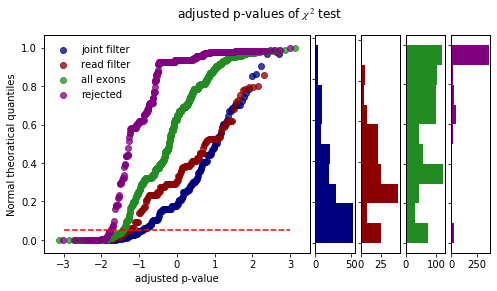

In [185]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min = 6)

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


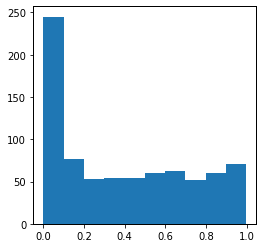

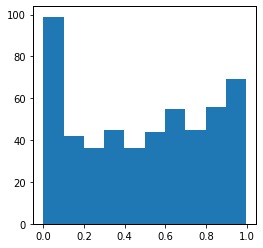

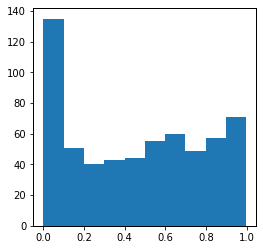

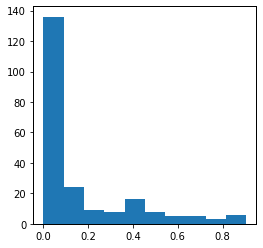

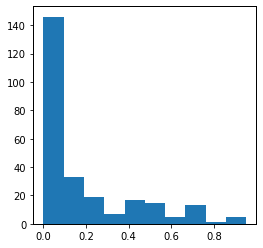

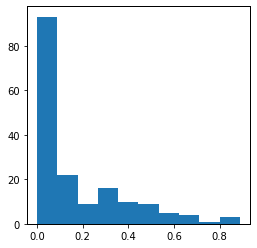

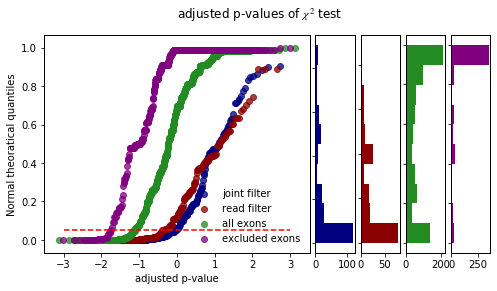

In [160]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 6, read_min = 6)

In [161]:
test_fisher_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 6, read_min = 6)

load_data.py:40: RuntimeWarning: invalid value encountered in true_divide
  sep='\t',  index_col=0)
R[write to console]: Error in (function (x, y = NULL, workspace = 2e+05, hybrid = FALSE, hybridPars = c(expect = 5,  : 
  FEXACT error 7(location). LDSTP=18600 is too small for this problem,
  (pastp=49.2715, ipn_0:=ipoin[itp=186]=227, stp[ipn_0]=46.913).
Increase workspace or consider using 'simulate.p.value=TRUE'



RRuntimeError: Error in (function (x, y = NULL, workspace = 2e+05, hybrid = FALSE, hybridPars = c(expect = 5,  : 
  FEXACT error 7(location). LDSTP=18600 is too small for this problem,
  (pastp=49.2715, ipn_0:=ipoin[itp=186]=227, stp[ipn_0]=46.913).
Increase workspace or consider using 'simulate.p.value=TRUE'


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


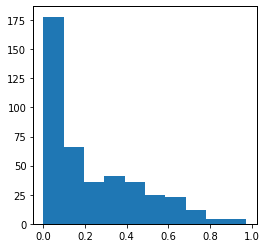

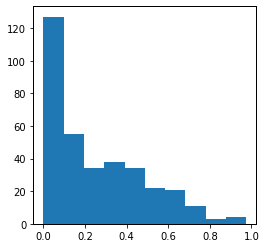

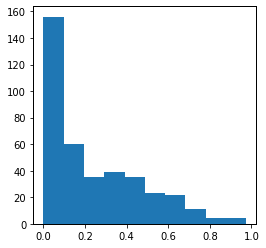

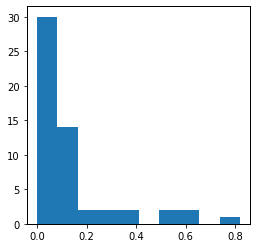

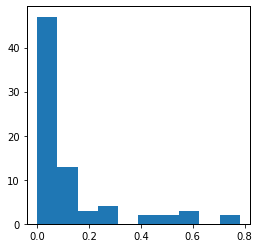

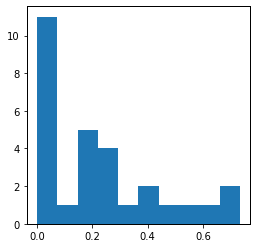

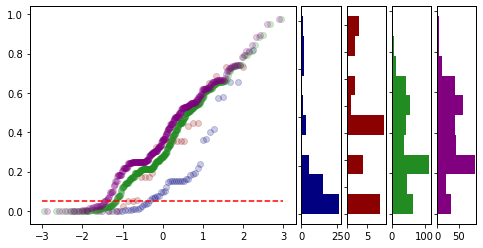

In [44]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.5, mrna_min = 10, read_min = 10)

In [31]:
# test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.cell_type, 
#                      psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 6, read_min = 6)

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


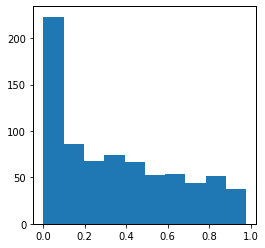

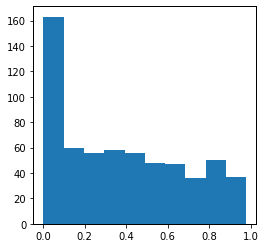

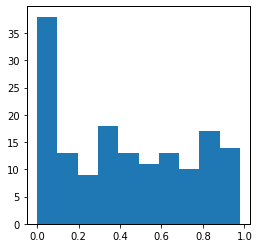

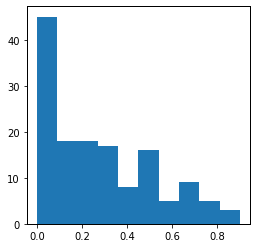

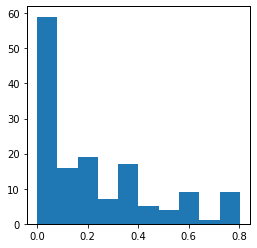

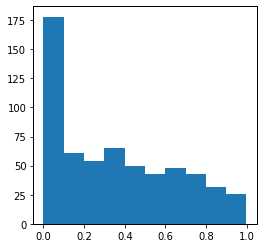

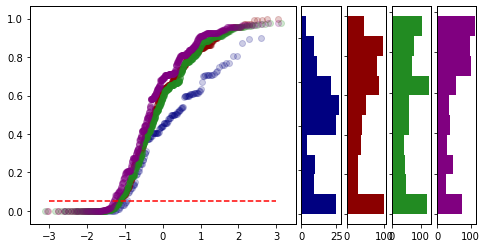

In [33]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min = 6)

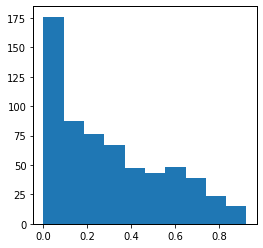

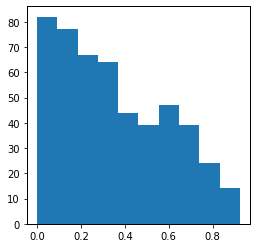

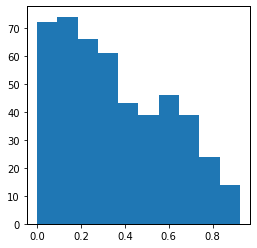

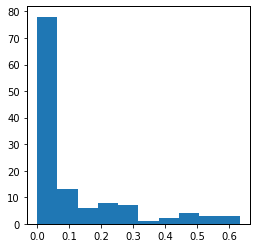

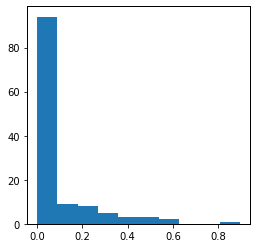

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


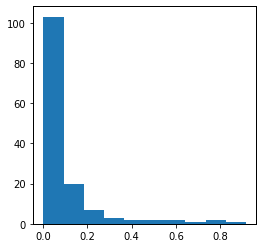

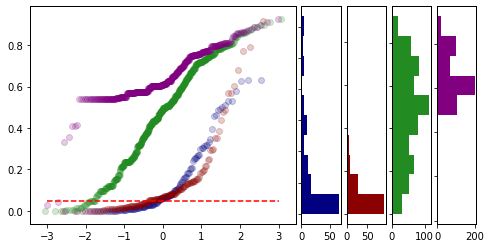

In [34]:
test_chi_filters(lescroart_PSI, lescroart_mrna_counts, mrna_per_event_lescroart, lescroart_read_counts, lescroart_coverage_tab, lescroart_pca_clust.cell_type, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min = 6)

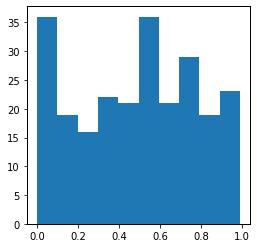

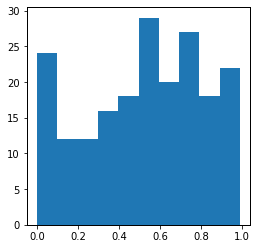

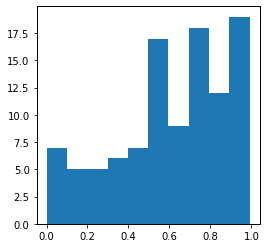

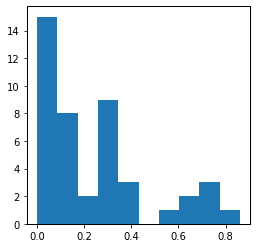

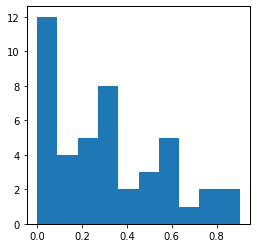

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


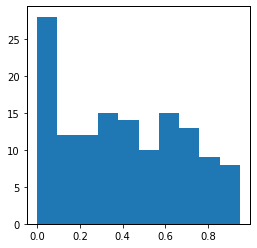

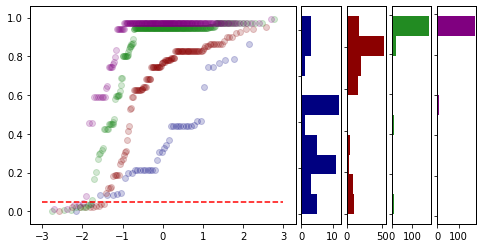

In [45]:
test_chi_filters(trapnell_PSI, trapnell_mrna_counts, mrna_per_event_trapnell, trapnell_read_counts, trapnell_coverage_tab, trapnell_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.5, mrna_min = 6, read_min = 6)

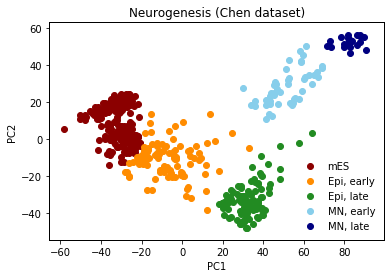

In [61]:
figsize(6, 4)
plt.scatter(chen_pca_clust.loc[chen_pca_clust.AC==0, 'PC1'], 
            chen_pca_clust.loc[chen_pca_clust.AC==0, 'PC2'], c='darkred', label='mES')
plt.scatter(chen_pca_clust.loc[chen_pca_clust.AC==1, 'PC1'], 
            chen_pca_clust.loc[chen_pca_clust.AC==1, 'PC2'], c='darkorange', label='Epi, early')
plt.scatter(chen_pca_clust.loc[chen_pca_clust.AC==2, 'PC1'], 
            chen_pca_clust.loc[chen_pca_clust.AC==2, 'PC2'], c='forestgreen', label='Epi, late')
plt.scatter(chen_pca_clust.loc[chen_pca_clust.AC==3, 'PC1'], 
            chen_pca_clust.loc[chen_pca_clust.AC==3, 'PC2'], c='skyblue', label='MN, early')
plt.scatter(chen_pca_clust.loc[chen_pca_clust.AC==4, 'PC1'], 
            chen_pca_clust.loc[chen_pca_clust.AC==4, 'PC2'], c='navy', label='MN, late')
plt.title('Neurogenesis (Chen dataset)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(frameon=False)
plt.show()

In [56]:
chen_pca_clust.loc['SRR2727109', 'AC']

0

In [63]:
import numpy as np
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

stats = importr('stats')
m = np.array([[4,4],[4,5],[10,6]])
res = stats.fisher_test(m)
print ('p-value: {}'.format(res[0][0]))

p-value: 0.6643639131198411


In [89]:
stats.fisher_test( np.array([[140,1],[121,2],[110,6], [110,2], [110,1]]))[0][0]

0.15445024327073673

In [99]:
stats.fisher_test(np.array([[140,1],[121,2],[110,6], [110,2], [110,1]]).T)[0][0]

0.15445024327073673

In [114]:
observed = chen_PSI.loc[chen_PSI.isna().mean(axis=1) <= (1-0.5)].index
chen_int_genes, chen_int_exons = spu.get_int_events(chen_PSI.loc[observed], chen_mrna_counts, 0.2)
    
aver = filter_psi(chen_PSI, chen_int_exons, mrna_per_event_chen, chen_coverage_tab['SJ_coverage'],
          chen_read_counts, 10, 0, 0.5)

# change_tab_all, chi_p_all = cluster_fisher_test(PSI_tab.loc[int_exons], clusters, psi_bin, print_extreme = print_extreme)

chen_unfiltered_exons = [x for x in chen_int_exons if x not in aver[0].index]

In [125]:
aver[0].index

Index(['0610010K14Rik_3', '0610010K14Rik_4', '1110038B12Rik_1',
       '2610318N02Rik_1', 'Anapc16_2', 'Atrx_4', 'Bclaf1_3', 'Cenpa_6',
       'Cenpa_nmdSE_1', 'Chtop_2', 'Clk1_1', 'Csde1_6', 'Cuedc2_1', 'Cuta_1',
       'Dph3_2', 'Eif4a2_1', 'Eif4e2_1', 'Eif4h_1', 'Erh_1', 'Fmr1nb_1',
       'Fxr1_1', 'G3bp2_1', 'Gas5_4', 'Hnrnpa2b1_1', 'Hnrnpa2b1_2',
       'Hnrnpab_1', 'Hnrnpc_1', 'Hnrnpd_3', 'Idh3g_1', 'Ift20_1', 'Immt_1',
       'Lsm6_2', 'Mff_3', 'Mrpl24_1', 'Mrpl30_3', 'Mrps17_1', 'Mrps17_4',
       'Mtf2_2', 'Mtf2_3', 'Nap1l4_1', 'Nsfl1c_2', 'Ociad1_1', 'Pcbp2_7',
       'Pla2g1b_1', 'Psmg4_1', 'Ptbp1_6', 'Puf60_1', 'Rabggtb_nmdSE_1',
       'Rbm39_nmdSE_2', 'Rer1_2', 'Rer1_3', 'Rnaseh2b_1', 'Rnps1_1',
       'Rsrc2_11', 'Rsrc2_6', 'Rsrp1_1', 'Smarcad1_3', 'Syce2_2', 'Tex30_5',
       'Thyn1_1', 'Timm9_2', 'Tmem134_1', 'Tmem234_nmdSE_1', 'Tor1aip2_3',
       'Tpd52l2_4', 'Tpd52l2_7', 'U2af1l4_6', 'U2surp_1', 'Ubap2l_3',
       'Ube2i_1', 'Ube2i_2', 'Vps29_2', 'Wfdc2_1', 'Wfdc2_

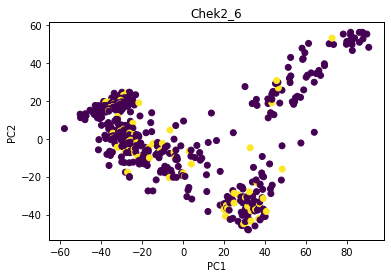

In [135]:
figsize(6, 4)
plt.scatter(chen_pca_clust.PC1, chen_pca_clust.PC2, c=(chen_PSI.loc['Chek2_6']>=0.75))#, cmap=cm.viridis)

plt.title('Chek2_6')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

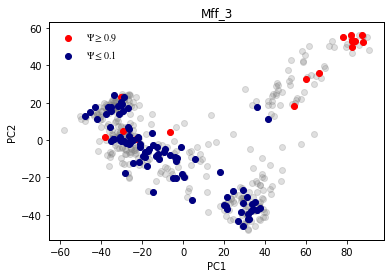

In [187]:
colores = []
pc1_i = []
pc2_i = []
pc1_e = []
pc2_e = []
for cell in chen_PSI.columns:
    if aver[0].loc['Mff_3', cell] >= 0.9:
        colores.append('red')
        pc1_i.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_i.append(chen_pca_clust.loc[cell, 'PC2'])
    elif aver[0].loc['Mff_3', cell] <= 0.1:
        colores.append('darkblue')
        pc1_e.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_e.append(chen_pca_clust.loc[cell, 'PC2'])
    
        
figsize(6, 4)
plt.scatter(chen_pca_clust.PC1, chen_pca_clust.PC2, c='grey', alpha=0.25)#, cmap=cm.viridis)
plt.scatter(pc1_i, pc2_i, c='red', label = '$\Psi \geq 0.9$')
plt.scatter(pc1_e, pc2_e, c='navy', label = '$\Psi \leq 0.1$')
plt.title('Mff_3')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(frameon=False)
plt.show()

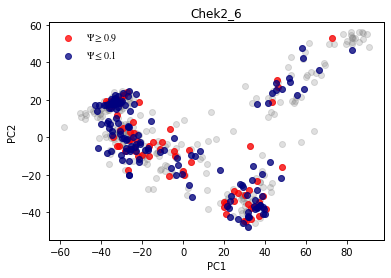

In [167]:
figsize(6, 4)

colores = []

    
pc1_i = []
pc2_i = []
pc1_e = []
pc2_e = []
for cell in chen_PSI.columns:
    if chen_PSI.loc['Chek2_6', cell] >= 0.9:
        colores.append('red')
        pc1_i.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_i.append(chen_pca_clust.loc[cell, 'PC2'])
    elif chen_PSI.loc['Chek2_6', cell] <= 0.1:
        colores.append('darkblue')
        pc1_e.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_e.append(chen_pca_clust.loc[cell, 'PC2'])
    
        
figsize(6, 4)
plt.scatter(chen_pca_clust.PC1, chen_pca_clust.PC2, c='grey', alpha=0.25)#, cmap=cm.viridis)
plt.scatter(pc1_i, pc2_i, c='red', label = '$\Psi \geq 0.9$', alpha=0.75)
plt.scatter(pc1_e, pc2_e, c='navy', label = '$\Psi \leq 0.1$', alpha=0.75)
plt.title('Chek2_6')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(frameon=False)

plt.show()

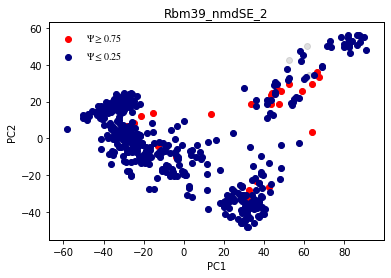

In [188]:
colores = []
pc1_i = []
pc2_i = []
pc1_e = []
pc2_e = []
for cell in chen_PSI.columns:
    if aver[0].loc['Rbm39_nmdSE_2', cell] >= 0.5:
        colores.append('red')
        pc1_i.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_i.append(chen_pca_clust.loc[cell, 'PC2'])
    elif aver[0].loc['Rbm39_nmdSE_2', cell] <= 0.5:
        colores.append('darkblue')
        pc1_e.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_e.append(chen_pca_clust.loc[cell, 'PC2'])
    
        
figsize(6, 4)
plt.scatter(chen_pca_clust.PC1, chen_pca_clust.PC2, c='grey', alpha=0.25)#, cmap=cm.viridis)
plt.scatter(pc1_i, pc2_i, c='red', label = '$\Psi \geq 0.75$')
plt.scatter(pc1_e, pc2_e, c='navy', label = '$\Psi \leq 0.25$')
plt.title('Rbm39_nmdSE_2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(frameon=False)
plt.show()

In [176]:
chisquare([0, 20, 0], [3, 21, 1])

Power_divergenceResult(statistic=4.0476190476190474, pvalue=0.1321510722856143)

In [266]:
def test_chi_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, 0)
    
#     assert aver_all[0].index == int_exons
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
          read_counts, 0, read_min, obs_min)
    
    aver_reads_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
          read_counts, 0, read_min, 0)
    
#     assert list(aver_all[0].index) == list(int_exons)
#     assert list(aver_reads_all[0].index) == list(int_exons)

    joint_idx = [x for x in int_exons if x in aver_all[0].index]
    joint_idx = [x for x in joint_idx if x in aver_reads_all[0].index]
    
    # Events that do not pass the filter
    
    change_tab, chi_p = cluster_chi_test(PSI_tab.loc[joint_idx], clusters, psi_bin)
    
    unfiltered_exons = [x for x in int_exons if x not in aver[0].index]
    unfiltered_exons_r = [x for x in int_exons if x not in aver_reads[0].index]
    
    
    osm_1 = get_osm(chi_p, change_tab.index)
    
    figsize(8, 4)
    fig = plt.figure()
    fig.suptitle('adjusted p-values of $\chi^2$ test')

    gs = GridSpec(6,11)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])

    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
    ax_marg_x5 = fig.add_subplot(gs[0:6,10])
    
    ax_joint.scatter(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'quantiles'],
               osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], c='navy', alpha = 0.1)
    
    ax_joint.scatter(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'quantiles'],
               osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], c='red', alpha = 0.1)
    
    ax_joint.plot([-3, 3], [0.05, 0.05], 'r--')
    
    ax_marg_x1.hist(chi_p, orientation="horizontal", color='purple')
    ax_marg_x2.hist(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], 
                    orientation="horizontal", color='red')
    ax_marg_x3.hist(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], 
                    orientation="horizontal", color='navy')
    
    ax_marg_x4.hist(osm_1.loc[[x for x in aver_reads[0].index if x in joint_idx], 'lista'], 
                    orientation="horizontal", color='darkorange')
    ax_marg_x5.hist(osm_1.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'], 
                    orientation="horizontal", color='forestgreen')
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x5.get_yticklabels(), visible=False)

    ax_joint.set_ylabel('adjusted p-value')
    ax_joint.set_xlabel('Normal theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


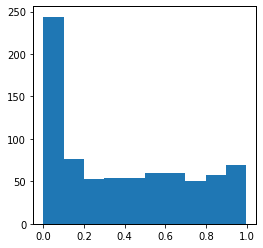

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
No handles with labels found to put in legend.


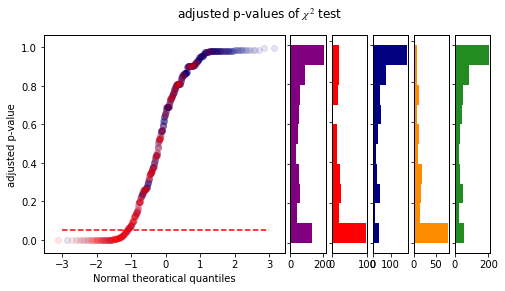

In [267]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 6, read_min = 6)

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


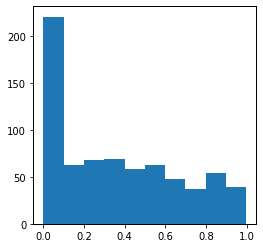

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
No handles with labels found to put in legend.


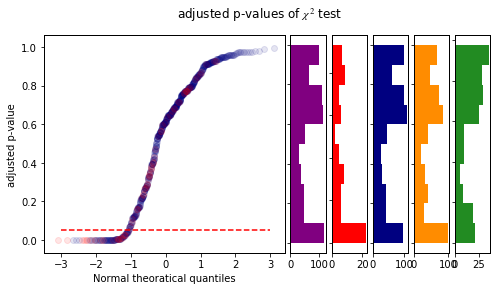

In [268]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 10, read_min = 10)

In [257]:
def test_chi_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, 0)
    
#     assert aver_all[0].index == int_exons
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
          read_counts, 0, read_min, obs_min)
    
    aver_reads_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
          read_counts, 0, read_min, 0)
    
#     assert list(aver_all[0].index) == list(int_exons)
#     assert list(aver_reads_all[0].index) == list(int_exons)

    joint_idx = [x for x in int_exons if x in aver_all[0].index]
    joint_idx = [x for x in joint_idx if x in aver_reads_all[0].index]
    
    # Events that do not pass the filter
    
#     change_tab, chi_p = cluster_chi_test(PSI_tab.loc[joint_idx], clusters, psi_bin)
    change_tab_aver, chi_p_aver = cluster_chi_test(aver_all[0].loc[joint_idx], clusters, psi_bin)
    change_tab_aver_reads, chi_p_aver_reads = cluster_chi_test(aver_reads_all[0].loc[joint_idx], clusters, psi_bin)
    
    unfiltered_exons = [x for x in int_exons if x not in aver[0].index]
    unfiltered_exons_r = [x for x in int_exons if x not in aver_reads[0].index]
    
    
    osm_1 = get_osm(chi_p_aver, change_tab_aver.index)
    osm_2 = get_osm(chi_p_aver_reads, change_tab_aver_reads.index)
    
    figsize(6, 4)
    fig = plt.figure()
    fig.suptitle('adjusted p-values of $\chi^2$ test')

    gs = GridSpec(6,10)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])

    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
#     ax_marg_x5 = fig.add_subplot(gs[0:6,9])


    ax_joint.scatter(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'quantiles'],
               osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], c='navy', alpha = 0.1)
    
    ax_joint.scatter(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'quantiles'],
               osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], c='red', alpha = 0.1)
    
    
    
    ax_joint.scatter(osm_2.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'quantiles'],
               osm_2.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'], c='forestgreen', alpha = 0.1)
    
    ax_joint.scatter(osm_2.loc[[x for x in aver_reads[0].index if x in joint_idx], 'quantiles'],
               osm_2.loc[[x for x in aver_reads[0].index if x in joint_idx], 'lista'], c='darkorange', alpha = 0.1)
    
    
    ax_joint.plot([-3, 3], [0.05, 0.05], 'r--')
    
    ax_marg_x1.hist(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], 
                    orientation="horizontal", color='navy')
    ax_marg_x2.hist(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], 
                    orientation="horizontal", color='red')
    
    ax_marg_x3.hist(osm_2.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'], 
                    orientation="horizontal", color='forestgreen')
    ax_marg_x4.hist(osm_2.loc[[x for x in aver_reads[0].index if x in joint_idx], 'lista'], 
                    orientation="horizontal", color='darkorange')
    
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)

    ax_joint.set_ylabel('adjusted p-value')
    ax_joint.set_xlabel('Normal theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


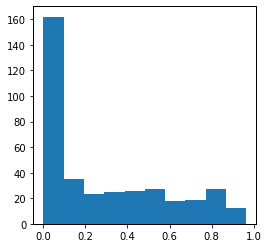

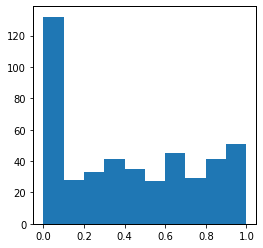

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
No handles with labels found to put in legend.


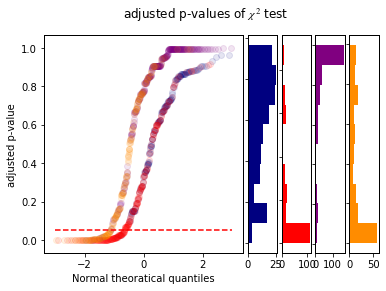

In [253]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 6, read_min = 6)

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


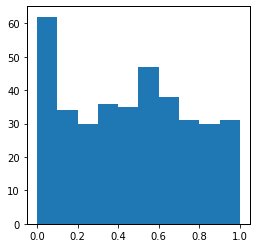

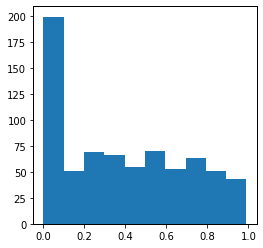

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
No handles with labels found to put in legend.


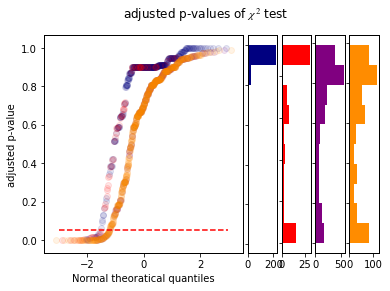

In [256]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 10, read_min = 10)

In [221]:
def get_osm(lista, index):
    n = len(lista)
    dframe = pd.DataFrame()
    dframe['lista'] = lista
    dframe_sorted = dframe.sort_values('lista')
    dframe_sorted['rank'] = np.array(range(n)) + 1
    dframe = dframe_sorted.loc[dframe.index]
#     np.array(dframe.sort_values('lista').index) + 1
#     dframe['rank'] = dframe_sorted
    
    val_list = []
    for idx in dframe.index:
        i = dframe.loc[idx, 'rank']
        if i == 1:
#             print('first')
            val = 1-0.5**(1/n)
        elif i == n:
#             print('last')
            val = 0.5**(1/n)
        else:
            val = (i - 0.3175) / (n + 0.365)
            
        val_list.append(val)
    dframe['val'] = val_list
    quantiles = norm.ppf(val_list)
    dframe['quantiles'] = quantiles
    
    dframe.index = index
    
    return dframe

In [206]:
dframe = pd.DataFrame()
dframe['lista'] = [0, 0.3, 0.2, 0.23, 1, 0.9, 0.54, 0.36, 0.87, 0, 0.03, 0.45, 0.6]

In [211]:
np.array(dframe.sort_values('lista').index)+1

array([ 1, 10, 11,  3,  4,  2,  8, 12,  7, 13,  9,  6,  5])

In [ ]:
quantiles = dist.ppf(val), for

        0.5**(1/n),                  for i = n
  val = (i - 0.3175) / (n + 0.365),  for i = 2, ..., n-1
        1 - 0.5**(1/n),              for i = 1

In [203]:
q = [0, 0.3, 0.2, 0.23, 1, 0.9, 0.54, 0.36, 0.87, 0, 0.03, 0.45, 0.6]
fracc = 1/len(q)
np.percentile(np.arange(0, len(q)+fracc, fracc), q)

array([0.    , 0.039 , 0.026 , 0.0299, 0.13  , 0.117 , 0.0702, 0.0468,
       0.1131, 0.    , 0.0039, 0.0585, 0.078 ])

In [199]:
np.arange(0, 1, 1/34)

array([0.        , 0.02941176, 0.05882353, 0.08823529, 0.11764706,
       0.14705882, 0.17647059, 0.20588235, 0.23529412, 0.26470588,
       0.29411765, 0.32352941, 0.35294118, 0.38235294, 0.41176471,
       0.44117647, 0.47058824, 0.5       , 0.52941176, 0.55882353,
       0.58823529, 0.61764706, 0.64705882, 0.67647059, 0.70588235,
       0.73529412, 0.76470588, 0.79411765, 0.82352941, 0.85294118,
       0.88235294, 0.91176471, 0.94117647, 0.97058824])

In [204]:
from scipy.stats import norm

In [269]:
def test_chi_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, 0)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
          read_counts, 0, read_min, obs_min)
    
    aver_reads_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
          read_counts, 0, read_min, 0)
    
    joint_idx = [x for x in int_exons if x in aver_all[0].index]
    joint_idx = [x for x in joint_idx if x in aver_reads_all[0].index]
        
    change_tab, chi_p = cluster_chi_test(PSI_tab.loc[joint_idx], clusters, psi_bin)
    
    unfiltered_exons = [x for x in int_exons if x not in aver[0].index]
    unfiltered_exons_r = [x for x in int_exons if x not in aver_reads[0].index]
    
    
    osm_1 = get_osm(chi_p, change_tab.index)
    
    figsize(8, 4)
    fig = plt.figure()
    fig.suptitle('adjusted p-values of $\chi^2$ test')

    gs = GridSpec(6,11)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])

    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
    ax_marg_x5 = fig.add_subplot(gs[0:6,10])
    
    ax_joint.scatter(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'quantiles'],
               osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], c='navy', alpha = 0.1)
    
    ax_joint.scatter(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'quantiles'],
               osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], c='red', alpha = 0.1)
    
    ax_joint.plot([-3, 3], [0.05, 0.05], 'r--')
    
    ax_marg_x1.hist(chi_p, orientation="horizontal", color='navy')
    ax_marg_x2.hist(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], 
                    orientation="horizontal", color='red')
    ax_marg_x3.hist(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], 
                    orientation="horizontal", color='purple')
    
    ax_marg_x4.hist(osm_1.loc[[x for x in aver_reads[0].index if x in joint_idx], 'lista'], 
                    orientation="horizontal", color='darkorange')
    ax_marg_x5.hist(osm_1.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'], 
                    orientation="horizontal", color='forestgreen')
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x5.get_yticklabels(), visible=False)

    ax_joint.set_ylabel('adjusted p-value')
    ax_joint.set_xlabel('Normal theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    M = len(chi_p)
    n = np.sum([x <= 0.05 for x in chi_p])
    
    N = len([x for x in aver[0].index if x in joint_idx])
    k = (osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'] <= 0.05).sum()
    
    print('filter')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))
    
    print('reads')
    
    N = len([x for x in aver_reads[0].index if x in joint_idx])
    k = (osm_1.loc[[x for x in aver_reads[0].index if x in joint_idx], 'lista'] <= 0.05).sum()
    
    
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


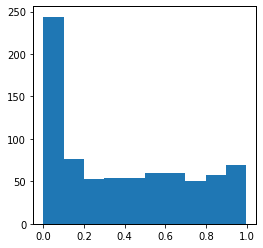

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3

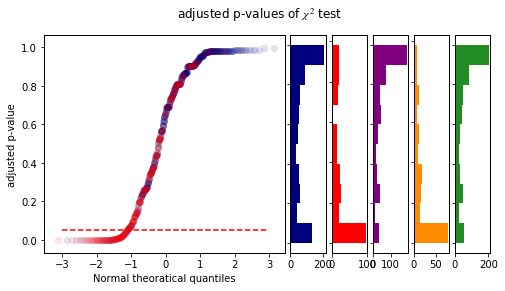

filter
779
104
268
77
(0.9999999999999177, 6.370393056562052e-19)
reads
779
104
186
63
(1.0, 3.5153994408933965e-18)


In [270]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 6, read_min = 6)

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


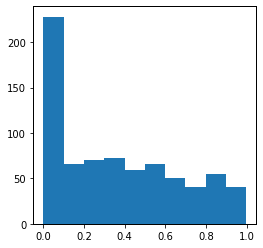

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
No handles with labels found to put in legend.


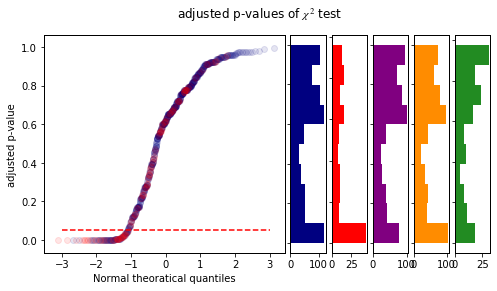

filter
748
103
148
40
(0.9999997151332942, 9.429405967197403e-07)
reads
748
103
609
89
(0.9421358310666251, 0.10012484911880999)


In [271]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 6, read_min = 6)

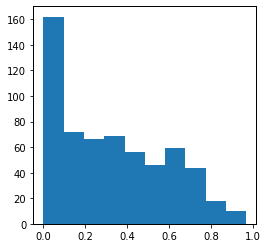

No handles with labels found to put in legend.


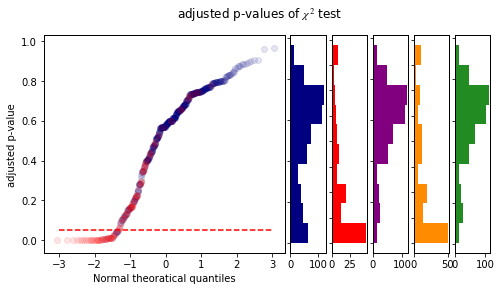

filter
602
54
125
42
(1.0, 1.922109461890386e-21)
reads
602
54
144
46
(0.9999999999999627, 1.0711022933532533e-23)


In [272]:
test_chi_filters(lescroart_PSI, lescroart_mrna_counts, mrna_per_event_lescroart, lescroart_read_counts, lescroart_coverage_tab, 
                 lescroart_pca_clust.cell_type, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 6, read_min = 6)

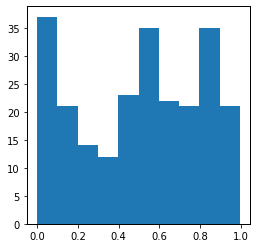

No handles with labels found to put in legend.


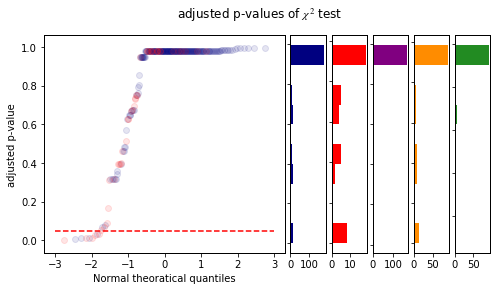

filter
241
9
44
5
(0.9985172894650628, 0.011655506229937081)
reads
241
9
137
9
(1.0, 0.00551346777854676)


In [275]:
test_chi_filters(trapnell_PSI, trapnell_mrna_counts, mrna_per_event_trapnell, trapnell_read_counts, trapnell_coverage_tab, 
                 trapnell_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 6, read_min = 6)

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


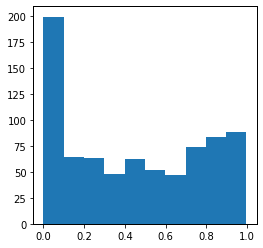

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3

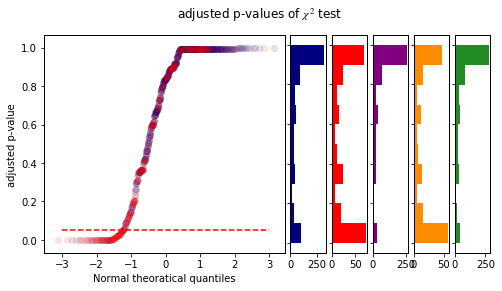

filter
780
82
268
61
(0.9999999999995395, 5.0924776343266645e-15)
reads
780
82
186
47
(0.9999999999989599, 4.3804922712382146e-12)


In [276]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.5, obs_min = 0.25, mrna_min = 6, read_min = 6)

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


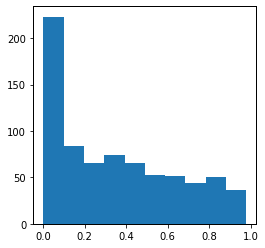

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
No handles with labels found to put in legend.


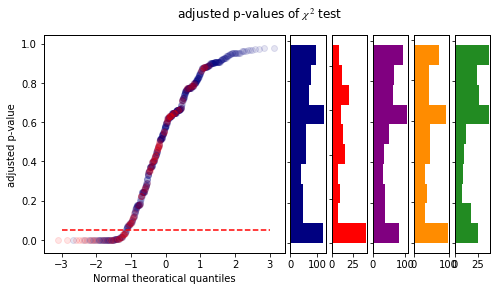

filter
746
94
148
33
(0.9999463625998979, 0.00014418587071763814)
reads
746
94
551
78
(0.9908007539391681, 0.018569486646459275)


In [279]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min =10)

In [301]:
def cluster_chi_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True, 
                     print_extreme=False, extreme = 0.9):
    cluster_array = []
    pvals = []
    exon_pass = []
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi[1] >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
#     if correct_multitest:
#         pvals_adj = multipletests(pvals, method=correction)[1]
#     else:
#         pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals



def test_chi_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, 0)
    
#     assert aver_all[0].index == int_exons
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
          read_counts, 0, read_min, obs_min)
    
    aver_reads_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
          read_counts, 0, read_min, 0)
    
#     assert list(aver_all[0].index) == list(int_exons)
#     assert list(aver_reads_all[0].index) == list(int_exons)

    joint_idx = [x for x in int_exons if x in aver_all[0].index]
    joint_idx = [x for x in joint_idx if x in aver_reads_all[0].index]
    
    # Events that do not pass the filter
    
    change_tab_aver, chi_p_aver = cluster_chi_test(aver_all[0].loc[joint_idx], clusters, psi_bin)
    change_tab_aver_reads, chi_p_aver_reads = cluster_chi_test(aver_reads_all[0].loc[joint_idx], clusters, psi_bin)
    
    print(len(chi_p_aver))
    print(len(chi_p_aver_reads))
    
    change_tab_aver['chi_p'] = chi_p_aver
    change_tab_aver_reads['chi_p'] = chi_p_aver_reads
    
    joint_idx = [x for x in change_tab_aver.index if x in change_tab_aver_reads.index]
    
    change_tab_aver = change_tab_aver.loc[joint_idx]
    change_tab_aver_reads = change_tab_aver_reads.loc[joint_idx]
    
    chi_p_aver = multipletests(list(change_tab_aver.chi_p), method='fdr_bh')[1]
    chi_p_aver_reads = multipletests(list(change_tab_aver_reads.chi_p), method='fdr_bh')[1]
    
    print(len(chi_p_aver))
    print(len(chi_p_aver_reads))
    
    osm_1 = get_osm(chi_p_aver, change_tab_aver.index)
    osm_2 = get_osm(chi_p_aver_reads, change_tab_aver_reads.index)
    
    figsize(6, 4)
    fig = plt.figure()
    fig.suptitle('adjusted p-values of $\chi^2$ test')

    gs = GridSpec(6,10)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])

    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
#     ax_marg_x5 = fig.add_subplot(gs[0:6,9])


    ax_joint.scatter(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'quantiles'],
               osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], c='navy', alpha = 0.1)
    
    ax_joint.scatter(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'quantiles'],
               osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], c='red', alpha = 0.1)
    
    ax_joint.scatter(osm_2.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'quantiles'],
               osm_2.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'], c='forestgreen', alpha = 0.1)
    
    ax_joint.scatter(osm_2.loc[[x for x in aver_reads[0].index if x in joint_idx], 'quantiles'],
               osm_2.loc[[x for x in aver_reads[0].index if x in joint_idx], 'lista'], c='darkorange', alpha = 0.1)
    
    
    ax_joint.plot([-3, 3], [0.05, 0.05], 'r--')
    
    ax_marg_x1.hist(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], 
                    orientation="horizontal", color='navy')
    ax_marg_x2.hist(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], 
                    orientation="horizontal", color='red')
    
    ax_marg_x3.hist(osm_2.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'], 
                    orientation="horizontal", color='forestgreen')
    ax_marg_x4.hist(osm_2.loc[[x for x in aver_reads[0].index if x in joint_idx], 'lista'], 
                    orientation="horizontal", color='darkorange')
    
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)

    ax_joint.set_ylabel('adjusted p-value')
    ax_joint.set_xlabel('Normal theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    
    
    M = len(chi_p_aver)
    n = np.sum([x <= 0.05 for x in chi_p_aver])
    
    N = len([x for x in aver[0].index if x in joint_idx])
    k = (osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'] <= 0.05).sum()
    
    print('filter')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))
    
    print('reads')
    
    
    M = len(chi_p_aver_reads)
    n = np.sum([x <= 0.05 for x in chi_p_aver_reads])
    N = len([x for x in aver_reads[0].index if x in joint_idx])
    k = (osm_2.loc[[x for x in aver_reads[0].index if x in joint_idx], 'lista'] <= 0.05).sum()
    
    
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))
    

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


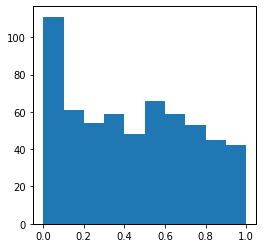

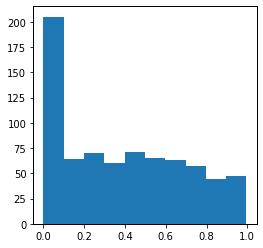

598
746
598
598


No handles with labels found to put in legend.


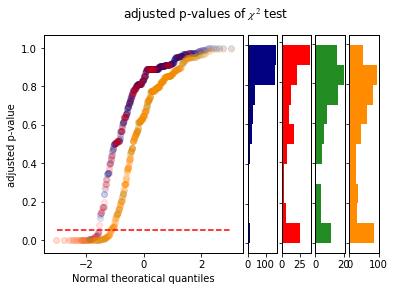

filter
598
36
145
24
(0.9999999961944143, 2.950939009652098e-08)
reads
598
75
509
65
(0.7106102209477356, 0.4207525983216621)


In [302]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 6, read_min =6)

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


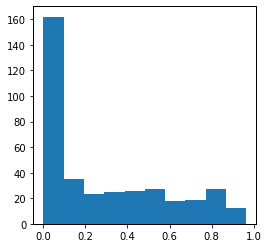

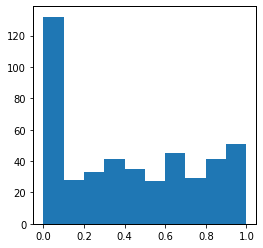

No handles with labels found to put in legend.


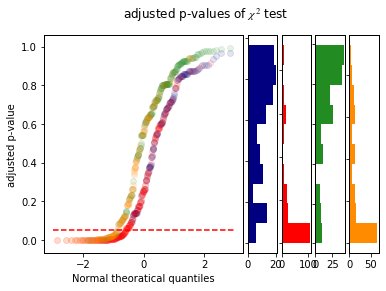

filter
332
91
211
87
(1.0, 2.6782512631730393e-16)
reads
332
64
155
56
(1.0, 5.991653088761053e-14)


In [297]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 6, read_min =6)

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


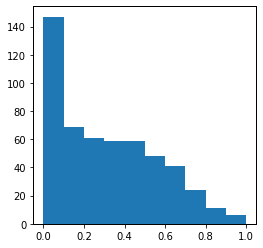

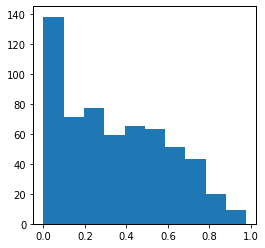

No handles with labels found to put in legend.


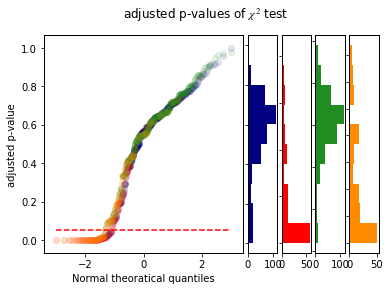

filter
522
71
125
55
(0.9999999999991724, 2.428777964527374e-25)
reads
522
48
144
47
(0.9999999999992913, 3.4861790780115407e-28)


In [298]:
test_chi_filters(lescroart_PSI, lescroart_mrna_counts, mrna_per_event_lescroart, lescroart_read_counts, lescroart_coverage_tab, 
                 lescroart_pca_clust.cell_type, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 6, read_min = 6)

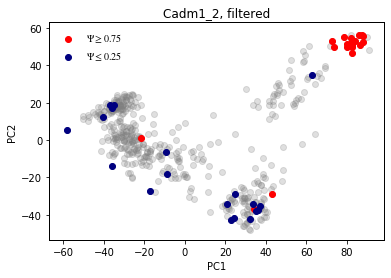

In [328]:
observed = chen_PSI.loc[chen_PSI.isna().mean(axis=1) <= (1-0.1)].index
int_genes, int_exons = spu.get_int_events(chen_PSI.loc[observed], chen_mrna_counts, 0.2)


aver = filter_psi(chen_PSI, int_exons, mrna_per_event_chen, chen_coverage_tab['nt_coverage'],
          chen_read_counts, 10, 0, 0.1)

colores = []
pc1_i = []
pc2_i = []
pc1_e = []
pc2_e = []
for cell in chen_PSI.columns:
    if aver[0].loc['Cadm1_2', cell] >= 0.75:
        colores.append('red')
        pc1_i.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_i.append(chen_pca_clust.loc[cell, 'PC2'])
    elif aver[0].loc['Cadm1_2', cell] <= 0.25:
        colores.append('darkblue')
        pc1_e.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_e.append(chen_pca_clust.loc[cell, 'PC2'])
    
        
figsize(6, 4)
plt.scatter(chen_pca_clust.PC1, chen_pca_clust.PC2, c='grey', alpha=0.25)#, cmap=cm.viridis)
plt.scatter(pc1_i, pc2_i, c='red', label = '$\Psi \geq 0.75$')
plt.scatter(pc1_e, pc2_e, c='navy', label = '$\Psi \leq 0.25$')
plt.title('Cadm1_2, filtered')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(frameon=False)
plt.show()

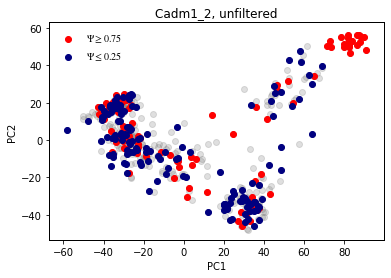

In [329]:
colores = []
pc1_i = []
pc2_i = []
pc1_e = []
pc2_e = []
for cell in chen_PSI.columns:
    if chen_PSI.loc['Cadm1_2', cell] >= 0.75:
        colores.append('red')
        pc1_i.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_i.append(chen_pca_clust.loc[cell, 'PC2'])
    elif chen_PSI.loc['Cadm1_2', cell] <= 0.25:
        colores.append('darkblue')
        pc1_e.append(chen_pca_clust.loc[cell, 'PC1'])
        pc2_e.append(chen_pca_clust.loc[cell, 'PC2'])
    
        
figsize(6, 4)
plt.scatter(chen_pca_clust.PC1, chen_pca_clust.PC2, c='grey', alpha=0.25)#, cmap=cm.viridis)
plt.scatter(pc1_i, pc2_i, c='red', label = '$\Psi \geq 0.75$')
plt.scatter(pc1_e, pc2_e, c='navy', label = '$\Psi \leq 0.25$')
plt.title('Cadm1_2, unfiltered')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(frameon=False)
plt.show()

In [334]:
def cluster_chi_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True, 
                     print_extreme=False, extreme = 0.9):
    cluster_array = []
    pvals = []
    exon_pass = []
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi[1] >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
#     if correct_multitest:
#         pvals_adj = multipletests(pvals, method=correction)[1]
#     else:
#         pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals



def test_chi_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    
#     assert aver_all[0].index == int_exons
    
#     aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
#           read_counts, 0, read_min, obs_min)
    
    
    # Events that do not pass the filter
    change_tab, chi_p = cluster_chi_test(PSI_tab.loc[aver[0].index], clusters, psi_bin)
    change_tab_aver, chi_p_aver = cluster_chi_test(aver[0], clusters, psi_bin)
    
    print(len(chi_p))
    print(len(chi_p_aver))
    
    change_tab['chi_p'] = chi_p
    change_tab_aver['chi_p'] = chi_p_aver
    
    joint_idx = [x for x in change_tab_aver.index if x in change_tab.index]
    
    change_tab_aver = change_tab_aver.loc[joint_idx]
    change_tab = change_tab.loc[joint_idx]
    
    chi_p_aver = multipletests(list(change_tab_aver.chi_p), method='fdr_bh')[1]
    chi_p = multipletests(list(change_tab.chi_p), method='fdr_bh')[1]
    
    print(len(chi_p_aver))
    print(len(chi_p))
    
    osm_1 = get_osm(chi_p_aver, change_tab_aver.index)
    osm_2 = get_osm(chi_p, change_tab.index)
    
    print(osm_1.shape)
    print(osm_2.shape)
    
    figsize(6, 4)
    fig = plt.figure()
    fig.suptitle('adjusted p-values of $\chi^2$ test')

    gs = GridSpec(6,8)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])

    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
#     ax_marg_x3 = fig.add_subplot(gs[0:6,8])
#     ax_marg_x4 = fig.add_subplot(gs[0:6,9])
#     ax_marg_x5 = fig.add_subplot(gs[0:6,9])


    ax_joint.scatter(osm_1.quantiles, osm_1.lista, c='navy', alpha = 0.1)
    ax_joint.scatter(osm_2.quantiles, osm_2.lista, c='red', alpha = 0.1)
    
    
    ax_joint.plot([-3, 3], [0.05, 0.05], 'r--')
    
    ax_marg_x1.hist(osm_1.lista, orientation="horizontal", color='navy')
    ax_marg_x2.hist(osm_2.lista, orientation="horizontal", color='red')
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    
    ax_joint.set_ylabel('adjusted p-value')
    ax_joint.set_xlabel('Normal theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    
    
#     M = len(chi_p_aver)
#     n = np.sum([x <= 0.05 for x in chi_p_aver])
    
#     N = len([x for x in aver[0].index if x in joint_idx])
#     k = (osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'] <= 0.05).sum()
    
#     print('filter')
    
#     print(M)
#     print(n)
#     print(N)
#     print(k)
    
#     print(hyper_test(M, n, N, k))
    
#     print('reads')
    
    
#     M = len(chi_p_aver_reads)
#     n = np.sum([x <= 0.05 for x in chi_p_aver_reads])
#     N = len([x for x in aver_reads[0].index if x in joint_idx])
#     k = (osm_2.loc[[x for x in aver_reads[0].index if x in joint_idx], 'lista'] <= 0.05).sum()
    
    
    
#     print(M)
#     print(n)
#     print(N)
#     print(k)
    
#     print(hyper_test(M, n, N, k))
    

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


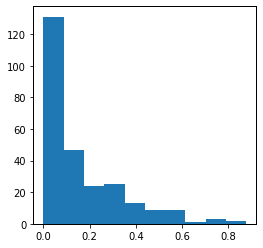

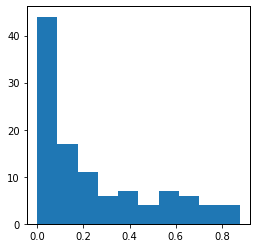

264
110
110
110
(110, 4)
(110, 4)


No handles with labels found to put in legend.


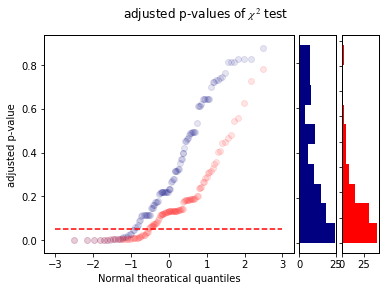

In [343]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.1, mrna_min = 10, read_min =6)

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


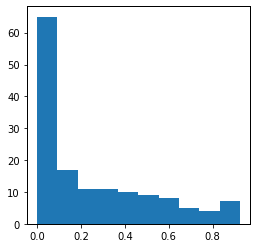

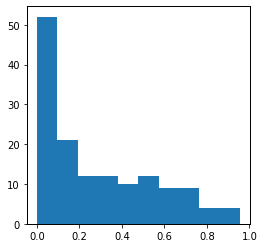

147
145
145
145
(145, 4)
(145, 4)


No handles with labels found to put in legend.


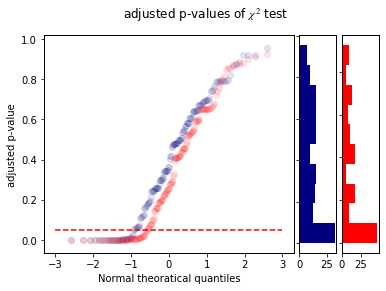

In [344]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 6, read_min =6)

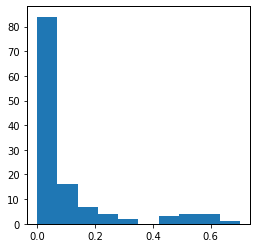

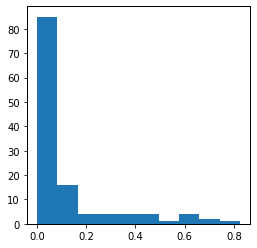

125
125
125
125
(125, 4)
(125, 4)


No handles with labels found to put in legend.


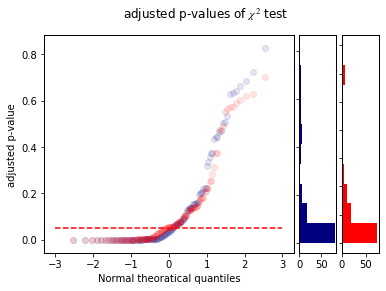

In [337]:
test_chi_filters(lescroart_PSI, lescroart_mrna_counts, mrna_per_event_lescroart, lescroart_read_counts, 
                 lescroart_coverage_tab, lescroart_pca_clust.cell_type, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 6, read_min =6)

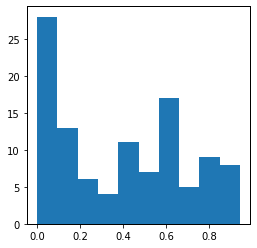

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


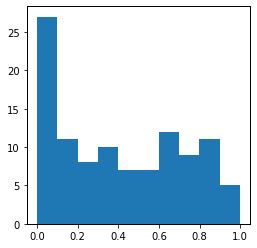

108
107
107
107
(107, 4)
(107, 4)


No handles with labels found to put in legend.


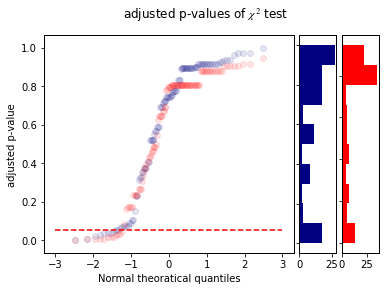

In [338]:
test_chi_filters(trapnell_PSI, trapnell_mrna_counts, mrna_per_event_trapnell, trapnell_read_counts, 
                 trapnell_coverage_tab, trapnell_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.25, mrna_min = 6, read_min =6)

In [388]:
def cluster_chi_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True, 
                     print_extreme=False, extreme = 0.9):
    cluster_array = []
    pvals = []
    exon_pass = []
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi_p >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
#     if correct_multitest:
#         pvals_adj = multipletests(pvals, method=correction)[1]
#     else:
#         pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals



def test_chi_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, obs_min)
    
    print(len(int_exons))
    print(aver[0].shape)
    print(aver_reads[0].shape)
    
#     observed = [x for x in aver[0].index if x in aver_reads[0].index]
    
    # Events that do not pass the filter
    change_tab, chi_p = cluster_chi_test(PSI_tab.loc[int_exons], clusters, psi_bin)
    change_tab_aver, chi_p_aver = cluster_chi_test(aver[0], clusters, psi_bin)
    change_tab_aver_reads, chi_p_aver_reads = cluster_chi_test(aver_reads[0], clusters, psi_bin)
    
    print(len(chi_p))
    print(len(chi_p_aver))
    print(len(chi_p_aver_reads))
    
    change_tab['chi_p'] = chi_p
    change_tab_aver['chi_p'] = chi_p_aver
    change_tab_aver_reads['chi_p'] = chi_p_aver_reads
    
#     joint_idx = [x for x in change_tab_aver.index if x in change_tab.index]
#     joint_idx = [x for x in change_tab_aver_reads.index if x in joint_idx]
    
#     change_tab_aver_reads = change_tab_aver_reads.loc[joint_idx]
#     change_tab_aver = change_tab_aver.loc[joint_idx]
#     change_tab = change_tab.loc[joint_idx]
    
#     chi_p_aver = multipletests(list(change_tab_aver.chi_p), method='fdr_bh')[1]
#     chi_p = multipletests(list(change_tab.chi_p), method='fdr_bh')[1]
    
    print(len(chi_p_aver))
    print(len(chi_p))
    print(len(chi_p_aver_reads))
    
    
    osm_1 = get_osm(change_tab.chi_p, change_tab.index)
    osm_2 = get_osm(change_tab_aver.chi_p, change_tab_aver.index)
    osm_3 = get_osm(change_tab_aver_reads.chi_p, change_tab_aver_reads.index)
    
    print(osm_1.shape)
    print(osm_2.shape)
    print(osm_3.shape)
    
    figsize(6, 4)
    fig = plt.figure()
    fig.suptitle('adjusted p-values of $\chi^2$ test')

    gs = GridSpec(6,9)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])

    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
#     ax_marg_x4 = fig.add_subplot(gs[0:6,9])
#     ax_marg_x5 = fig.add_subplot(gs[0:6,9])


    ax_joint.scatter(osm_1.quantiles, osm_1.lista, c='purple', alpha = 0.5)
    ax_joint.scatter(osm_2.quantiles, osm_2.lista, c='navy', alpha = 0.5)
    ax_joint.scatter(osm_3.quantiles, osm_3.lista, c='red', alpha = 0.5)
    
    
    ax_joint.plot([-3, 3], [0.05, 0.05], 'r--')
    
    ax_marg_x1.hist(osm_1.lista, orientation="horizontal", color='purple')
    ax_marg_x2.hist(osm_2.lista, orientation="horizontal", color='navy')
    ax_marg_x3.hist(osm_3.lista, orientation="horizontal", color='red')
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    
    ax_joint.set_ylabel('adjusted p-value')
    ax_joint.set_xlabel('Normal theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    
    
#     M = len(chi_p_aver)
#     n = np.sum([x <= 0.05 for x in chi_p_aver])
    
#     N = len([x for x in aver[0].index if x in joint_idx])
#     k = (osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'] <= 0.05).sum()
    
#     print('filter')
    
#     print(M)
#     print(n)
#     print(N)
#     print(k)
    
#     print(hyper_test(M, n, N, k))
    
#     print('reads')
    
    
#     M = len(chi_p_aver_reads)
#     n = np.sum([x <= 0.05 for x in chi_p_aver_reads])
#     N = len([x for x in aver_reads[0].index if x in joint_idx])
#     k = (osm_2.loc[[x for x in aver_reads[0].index if x in joint_idx], 'lista'] <= 0.05).sum()
    
    
    
#     print(M)
#     print(n)
#     print(N)
#     print(k)
    
#     print(hyper_test(M, n, N, k))
    

813
(158, 488)
(92, 488)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


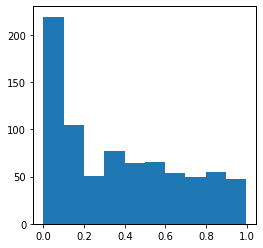

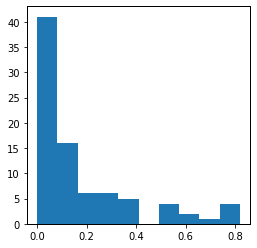

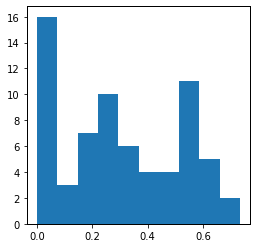

786
85
68
85
786
68
(786, 4)
(85, 4)
(68, 4)


No handles with labels found to put in legend.


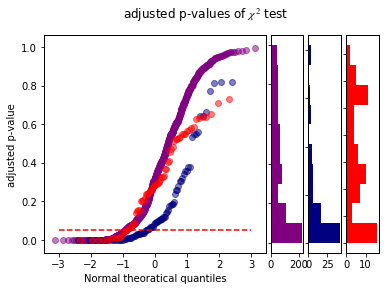

In [389]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10)

778
(76, 202)
(554, 202)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


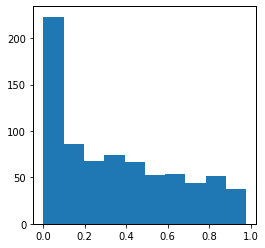

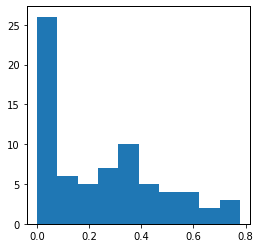

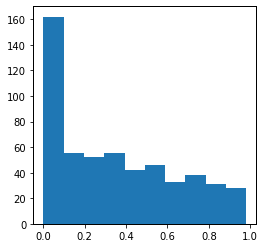

757
72
542
72
757
542
(757, 4)
(72, 4)
(542, 4)


No handles with labels found to put in legend.


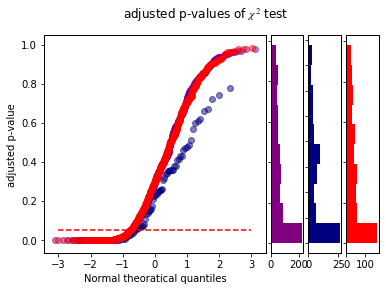

In [390]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10)

622
(497, 513)
(611, 513)


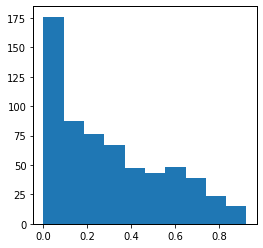

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


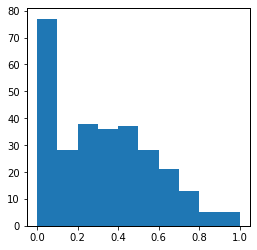

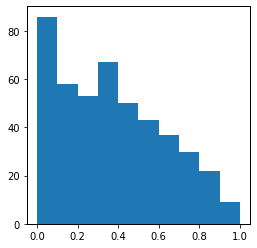

622
288
455
288
622
455
(622, 4)
(288, 4)
(455, 4)


No handles with labels found to put in legend.


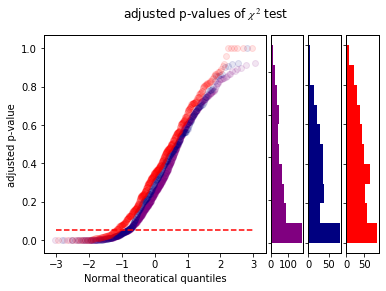

In [383]:
test_chi_filters(lescroart_PSI, lescroart_mrna_counts, mrna_per_event_lescroart, lescroart_read_counts, 
                 lescroart_coverage_tab, lescroart_pca_clust.cell_type, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10)

In [428]:
def cluster_chi_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True, 
                     print_extreme=False, extreme = 0.9):
    cluster_array = []
    pvals = []
    exon_pass = []
    not_pass = 0
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi_p >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        else:
            not_pass += 1
        
    print('not pass')
    print(not_pass)
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
#     if correct_multitest:
#         pvals_adj = multipletests(pvals, method=correction)[1]
#     else:
#         pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals


def test_chi_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10, filter_obs = False):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, 0)

    joint_idx = [x for x in int_exons if x in aver_all[0].index]
    print(len(joint_idx))
#     joint_idx = [x for x in joint_idx if x in aver_reads_all[0].index]
    
    # Events that do not pass the filter
    
    print(aver_all[0].shape)
    
    if filter_obs:
        change_tab, chi_p = cluster_chi_test(aver_all[0].loc[joint_idx], clusters, psi_bin)
    else:
        change_tab, chi_p = cluster_chi_test(PSI_tab.loc[joint_idx], clusters, psi_bin)
    
    change_tab['pvals'] = chi_p
    
    print(change_tab.shape)
    
    osm_1 = get_osm(chi_p, change_tab.index)
    
    figsize(8, 4)
    fig = plt.figure()
    
    if filter_obs:
        fig.suptitle('p-values of $\chi^2$ test; selected observations')
    else:
        fig.suptitle('p-values of $\chi^2$ test; all observations')

    gs = GridSpec(6,9)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])

    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
#     ax_marg_x4 = fig.add_subplot(gs[0:6,9])
#     ax_marg_x5 = fig.add_subplot(gs[0:6,10])
    
    ax_joint.scatter(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'quantiles'],
               osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], c='navy', alpha = 0.5,
                    label='rejected')
    
    ax_joint.scatter(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'quantiles'],
               osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], c='red', alpha = 0.5, 
                     label='selected')
    
    ax_joint.plot([-3, 3], [0.05, 0.05], 'r--')
    
    ax_marg_x3.hist(chi_p, orientation="horizontal", color='purple', bins=20)
    ax_marg_x1.hist(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], 
                    orientation="horizontal", color='red', bins=20)
    ax_marg_x2.hist(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], 
                    orientation="horizontal", color='navy', bins=20)
    
#     ax_marg_x4.hist(osm_1.loc[[x for x in aver_reads[0].index if x in joint_idx], 'lista'], 
#                     orientation="horizontal", color='darkorange')
#     ax_marg_x5.hist(osm_1.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'], 
#                     orientation="horizontal", color='forestgreen')
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
#     plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
#     plt.setp(ax_marg_x5.get_yticklabels(), visible=False)

    ax_joint.set_ylabel('un adjusted p-value')
    ax_joint.set_xlabel('Normal theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    M = len(chi_p)
    n = np.sum([x <= 0.05 for x in chi_p])
    
    print(osm_1.shape)
    
    N = len([x for x in aver[0].index if x in osm_1.index])
    k = (osm_1.loc[[x for x in aver[0].index if x in osm_1.index], 'lista'] <= 0.05).sum()
    
    print('filter')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))

733
(733, 488)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
27


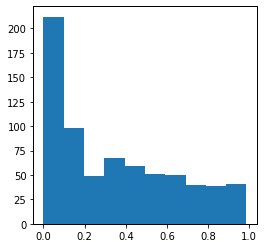

(706, 6)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


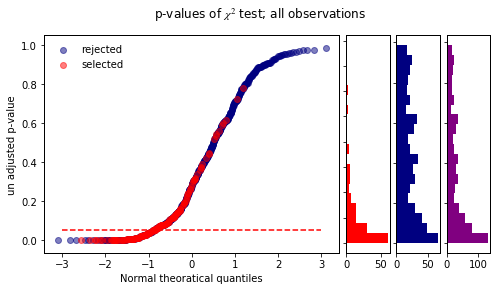

(706, 4)
filter
706
132
157
66
(1.0, 1.938632478585101e-15)


In [429]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10)

733
(733, 488)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
607


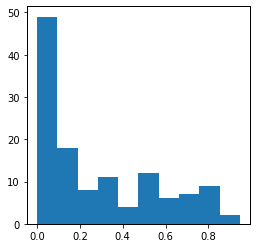

(126, 6)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


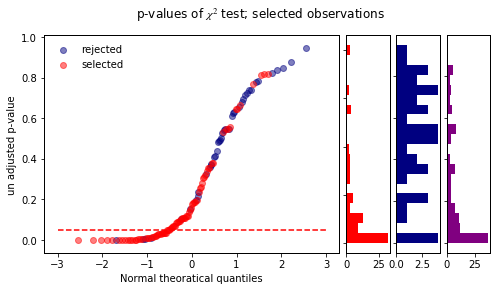

(126, 4)
filter
126
39
85
35
(0.9999733367687581, 0.00019118958112307376)


In [431]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, filter_obs = True)

767
(767, 202)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
21


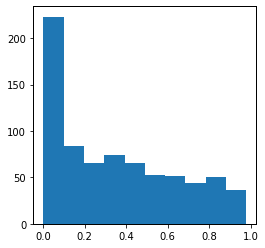

(746, 4)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


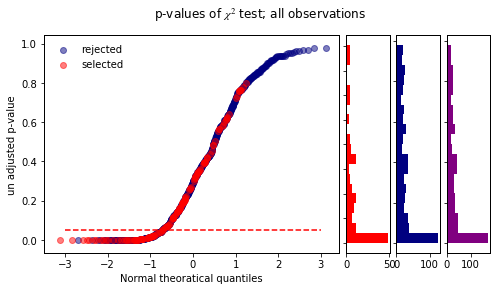

(746, 4)
filter
746
175
146
50
(0.9997025620708399, 0.0006221467803456282)


In [433]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min =10)

767
(767, 202)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
183


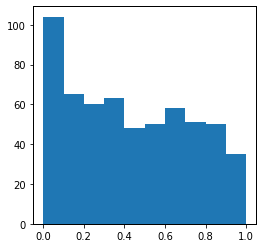

(584, 4)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


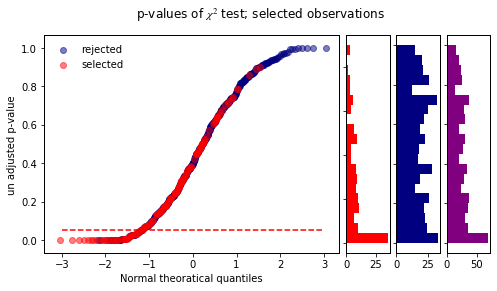

(584, 4)
filter
584
69
144
36
(0.9999999712013676, 1.2438711599963142e-07)


In [434]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min =10, filter_obs=True)

733
(733, 488)
not pass
463


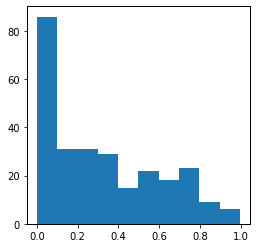

(270, 5)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


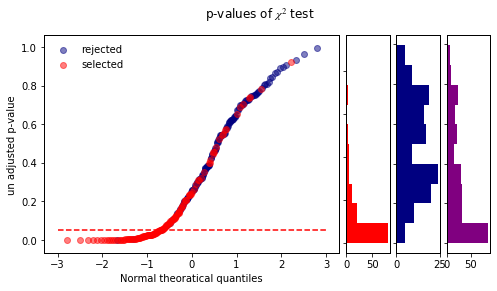

(270, 4)
filter
270
63
136
61
(1.0, 9.096057496308661e-20)


In [425]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.cell_type, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, filter_obs = True)

In [437]:
def cluster_chi_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True, 
                     print_extreme=False, extreme = 0.9):
    cluster_array = []
    pvals = []
    exon_pass = []
    not_pass = 0
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi_p >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        else:
            not_pass += 1
        
    print('not pass')
    print(not_pass)
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
#     if correct_multitest:
#         pvals_adj = multipletests(pvals, method=correction)[1]
#     else:
#         pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals


def test_chi_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10, filter_obs = False):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, obs_min)
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, 0)
    
    aver_all_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, 0)

    joint_idx = [x for x in int_exons if x in aver_all[0].index]
    joint_idx = [x for x in joint_idx if x in aver_all_reads[0].index]
    print(len(joint_idx))
#     joint_idx = [x for x in joint_idx if x in aver_reads_all[0].index]
    
    # Events that do not pass the filter
    
    print(aver_all[0].shape)
    print(aver_all_reads[0].shape)
    
    if filter_obs:
        change_tab, chi_p = cluster_chi_test(aver_all[0].loc[joint_idx], clusters, psi_bin)
    else:
        change_tab, chi_p = cluster_chi_test(PSI_tab.loc[joint_idx], clusters, psi_bin)
    
    change_tab['pvals'] = chi_p
    
    print(change_tab.shape)
    
    osm_1 = get_osm(chi_p, change_tab.index)
    
    figsize(8, 4)
    fig = plt.figure()
    
    if filter_obs:
        fig.suptitle('p-values of $\chi^2$ test; selected observations')
    else:
        fig.suptitle('p-values of $\chi^2$ test; all observations')

    gs = GridSpec(6,11)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])

    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
    ax_marg_x5 = fig.add_subplot(gs[0:6,10])
    
    ax_joint.scatter(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'quantiles'],
               osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], c='navy', alpha = 0.5,
                    label='rejected')
    
    ax_joint.scatter(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'quantiles'],
               osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], c='red', alpha = 0.5, 
                     label='selected')
    
    ax_joint.plot([-3, 3], [0.05, 0.05], 'r--')
    
    ax_marg_x3.hist(chi_p, orientation="horizontal", color='purple', bins=20)
    ax_marg_x1.hist(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], 
                    orientation="horizontal", color='red', bins=20)
    ax_marg_x2.hist(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], 
                    orientation="horizontal", color='navy', bins=20)
    
    ax_marg_x4.hist(osm_1.loc[[x for x in aver_reads[0].index if x in joint_idx], 'lista'], 
                    orientation="horizontal", color='darkorange', bins=20)
    ax_marg_x5.hist(osm_1.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'], 
                    orientation="horizontal", color='forestgreen', bins=20)
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x5.get_yticklabels(), visible=False)

    ax_joint.set_ylabel('un adjusted p-value')
    ax_joint.set_xlabel('Normal theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    M = len(chi_p)
    n = np.sum([x <= 0.05 for x in chi_p])
    
    print(osm_1.shape)
    
    N = len([x for x in aver[0].index if x in osm_1.index])
    k = (osm_1.loc[[x for x in aver[0].index if x in osm_1.index], 'lista'] <= 0.05).sum()
    
    print('filter')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))
    
    
    
    N = len([x for x in aver_reads[0].index if x in osm_1.index])
    k = (osm_1.loc[[x for x in aver_reads[0].index if x in osm_1.index], 'lista'] <= 0.05).sum()
    
    print('reads')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))

707
(733, 488)
(769, 488)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
27


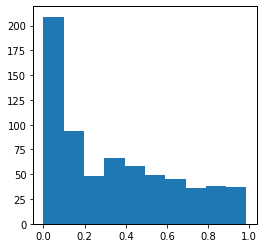

(680, 6)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


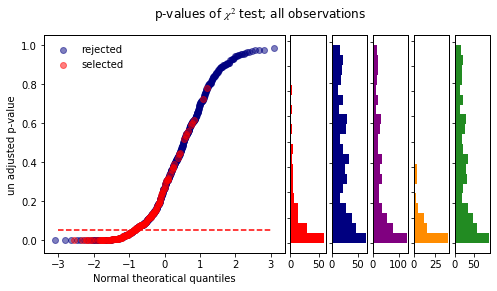

(680, 4)
filter
680
131
157
66
(0.9999999999991362, 9.348899643261109e-15)
reads
680
131
92
42
(0.9999999999405351, 2.909652460926646e-10)


In [438]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10)

767
(767, 202)
(778, 202)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
21


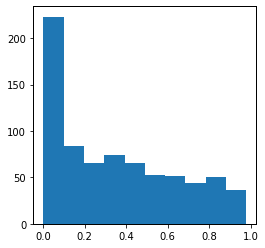

(746, 4)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


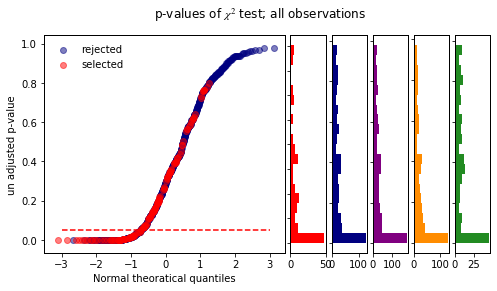

(746, 4)
filter
746
175
146
50
(0.9997025620708399, 0.0006221467803456282)
reads
746
175
540
130
(0.7689739221325559, 0.29450603584192325)


In [439]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min =10)

767
(767, 202)
(778, 202)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
183


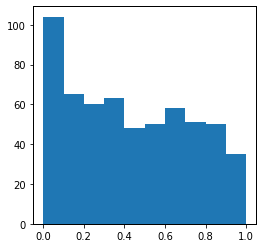

(584, 4)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


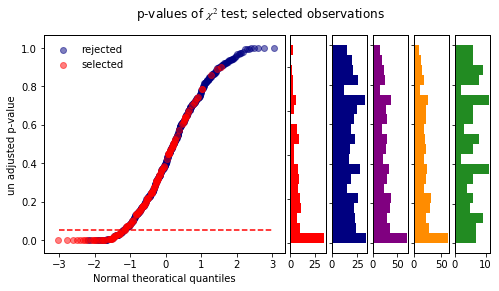

(584, 4)
filter
584
69
144
36
(0.9999999712013676, 1.2438711599963142e-07)
reads
584
69
456
62
(0.9979540268267914, 0.006152992514077212)


In [442]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min =10, filter_obs=True)

In [450]:
def cluster_chi_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True, 
                     print_extreme=False, extreme = 0.9):
    cluster_array = []
    pvals = []
    exon_pass = []
    not_pass = 0
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi_p >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        else:
            not_pass += 1
        
    print('not pass')
    print(not_pass)
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
#     if correct_multitest:
#         pvals_adj = multipletests(pvals, method=correction)[1]
#     else:
#         pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals


def test_chi_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10, filter_obs = False):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, obs_min)
    
    aver_all = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, 0)
    
    aver_all_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, 0)

    joint_idx = [x for x in int_exons if x in aver_all[0].index]
    joint_idx = [x for x in joint_idx if x in aver_all_reads[0].index]
    print(len(joint_idx))
#     joint_idx = [x for x in joint_idx if x in aver_reads_all[0].index]
    
    # Events that do not pass the filter
    
    print(aver_all[0].shape)
    print(aver_all_reads[0].shape)
    
    if filter_obs:
        change_tab, chi_p = cluster_chi_test(aver_all[0].loc[joint_idx], clusters, psi_bin)
    else:
        change_tab, chi_p = cluster_chi_test(PSI_tab.loc[joint_idx], clusters, psi_bin)
    
    change_tab['pvals'] = chi_p
    
    print(change_tab.shape)
    
    osm_1 = get_osm(chi_p, change_tab.index)
    
    figsize(8, 4)
    fig = plt.figure()
    
    if filter_obs:
        fig.suptitle('p-values of $\chi^2$ test; selected observations')
    else:
        fig.suptitle('p-values of $\chi^2$ test; all observations')

    gs = GridSpec(6,11)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])

    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
    ax_marg_x4 = fig.add_subplot(gs[0:6,9])
    ax_marg_x5 = fig.add_subplot(gs[0:6,10])
    
    
    ax_joint.scatter(probplot(osm_1.lista)[0][0], 
                     probplot(osm_1.lista)[0][1], 
                     alpha = 0.5, c='purple', label='all')
    
    
    ax_joint.scatter(probplot(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'])[0][0], 
                     probplot(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'])[0][1], 
                     alpha = 0.5, c='navy', label='rejected')
    
    
    ax_joint.scatter(probplot(osm_1.loc[[x for x in joint_idx if x in aver[0].index], 'lista'])[0][0], 
                     probplot(osm_1.loc[[x for x in joint_idx if x in aver[0].index], 'lista'])[0][1], 
                     alpha = 0.5, c='red', label='selected')
    
    
    ax_joint.scatter(probplot(osm_1.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'])[0][0], 
                     probplot(osm_1.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'])[0][1], 
                     alpha = 0.5, c='forestgreen', label='rejected reads')
    
    ax_joint.scatter(probplot(osm_1.loc[[x for x in joint_idx if x in aver_reads[0].index], 'lista'])[0][0], 
                     probplot(osm_1.loc[[x for x in joint_idx if x in aver_reads[0].index], 'lista'])[0][1], 
                     alpha = 0.5, c='darkorange', label='selected reads')
    
    
    
    
#     ax_joint.scatter(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'quantiles'],
#                osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], c='navy', alpha = 0.5,
#                     label='rejected')
    
#     ax_joint.scatter(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'quantiles'],
#                osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], c='red', alpha = 0.5, 
#                      label='selected')
    
    ax_joint.plot([-3, 3], [0.05, 0.05], 'r--')
    
    ax_marg_x3.hist(chi_p, orientation="horizontal", color='purple', bins=20)
    ax_marg_x1.hist(osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'], 
                    orientation="horizontal", color='red', bins=20)
    ax_marg_x2.hist(osm_1.loc[[x for x in joint_idx if x not in aver[0].index], 'lista'], 
                    orientation="horizontal", color='navy', bins=20)
    
    ax_marg_x4.hist(osm_1.loc[[x for x in aver_reads[0].index if x in joint_idx], 'lista'], 
                    orientation="horizontal", color='darkorange', bins=20)
    ax_marg_x5.hist(osm_1.loc[[x for x in joint_idx if x not in aver_reads[0].index], 'lista'], 
                    orientation="horizontal", color='forestgreen', bins=20)
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x4.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x5.get_yticklabels(), visible=False)

    ax_joint.set_ylabel('un adjusted p-value')
    ax_joint.set_xlabel('Normal theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    M = len(chi_p)
    n = np.sum([x <= 0.05 for x in chi_p])
    
    print(osm_1.shape)
    
    N = len([x for x in aver[0].index if x in osm_1.index])
    k = (osm_1.loc[[x for x in aver[0].index if x in osm_1.index], 'lista'] <= 0.05).sum()
    
    print('filter')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))
    
    
    
    N = len([x for x in aver_reads[0].index if x in osm_1.index])
    k = (osm_1.loc[[x for x in aver_reads[0].index if x in osm_1.index], 'lista'] <= 0.05).sum()
    
    print('reads')
    
    print(M)
    print(n)
    print(N)
    print(k)
    
    print(hyper_test(M, n, N, k))

707
(733, 488)
(769, 488)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
27


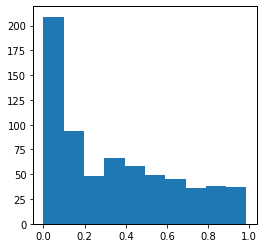

(680, 6)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3

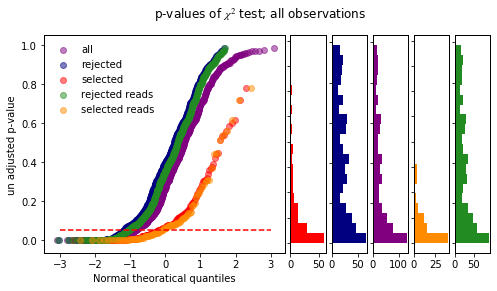

(680, 4)
filter
680
131
157
66
(0.9999999999991362, 9.348899643261109e-15)
reads
680
131
92
42
(0.9999999999405351, 2.909652460926646e-10)


In [445]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10)

707
(733, 488)
(769, 488)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
581


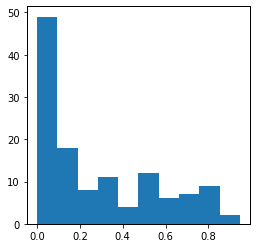

(126, 6)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3

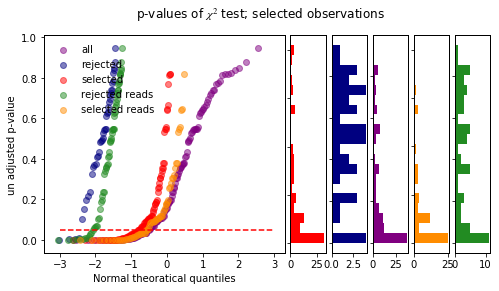

(126, 4)
filter
126
39
85
35
(0.9999733367687581, 0.00019118958112307376)
reads
126
39
63
27
(0.9990773249126351, 0.0032898653714754306)


In [451]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10, filter_obs=True)

767
(767, 202)
(778, 202)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


not pass
21


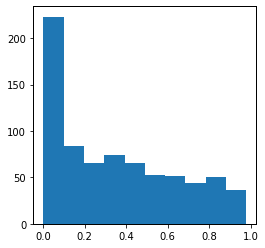

(746, 4)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


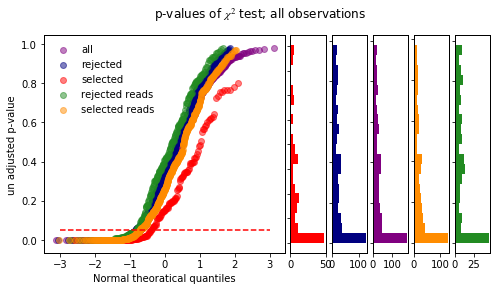

(746, 4)
filter
746
175
146
50
(0.9997025620708399, 0.0006221467803456282)
reads
746
175
540
130
(0.7689739221325559, 0.29450603584192325)


In [446]:
test_chi_filters(song_PSI, song_mrna_counts, mrna_per_event_song, song_read_counts, song_coverage_tab, song_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 6, read_min =10)

In [448]:
def cluster_chi_test(PSI_tab, clusters, psi_lim, correction = 'fdr_bh', correct_multitest = True, 
                     print_extreme=False, extreme = 0.9):
    cluster_array = []
    pvals = []
    exon_pass = []
    for exon in PSI_tab.index:
        chi_p, pos, neg, exp = test_exon_bimodal_chi(PSI_tab, exon, clusters, psi_lim = psi_lim)
        if not np.isnan(chi_p):
            cluster_array.append(pos/(neg+pos))
            pvals.append(chi_p)
            exon_pass.append(exon)
            
            if print_extreme:
                if chi_p >= extreme:
                    print(pos)
                    print(neg)
                    print(exp)
        
    figsize(4, 4)
    plt.hist(pvals)
    plt.show()
#     if correct_multitest:
#         pvals_adj = multipletests(pvals, method=correction)[1]
#     else:
#         pvals_adj = pvals
    cluster_df = pd.DataFrame(cluster_array)
    cluster_df.index = exon_pass
    
    return cluster_df, pvals



def test_chi_filters(PSI_tab, mrna_counts, mrna_per_event, read_counts, coverage_tab, clusters, 
                     psi_min = 0.2, psi_bin = 0.25, obs_min = 0.5, mrna_min = 10, read_min = 10):
    
    observed = PSI_tab.loc[PSI_tab.isna().mean(axis=1) <= (1-obs_min)].index
    int_genes, int_exons = spu.get_int_events(PSI_tab.loc[observed], mrna_counts, psi_min)


    aver = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, mrna_min, 0, obs_min)
    
    aver_reads = filter_psi(PSI_tab, int_exons, mrna_per_event, coverage_tab['SJ_coverage'],
              read_counts, 0, read_min, obs_min)
    
    print(len(int_exons))
    print(aver[0].shape)
    print(aver_reads[0].shape)
    
#     observed = [x for x in aver[0].index if x in aver_reads[0].index]
    
    # Events that do not pass the filter
    change_tab, chi_p = cluster_chi_test(PSI_tab.loc[int_exons], clusters, psi_bin)
    change_tab_aver, chi_p_aver = cluster_chi_test(aver[0], clusters, psi_bin)
    change_tab_aver_reads, chi_p_aver_reads = cluster_chi_test(aver_reads[0], clusters, psi_bin)
    
    print(len(chi_p))
    print(len(chi_p_aver))
    print(len(chi_p_aver_reads))
    
    change_tab['chi_p'] = chi_p
    change_tab_aver['chi_p'] = chi_p_aver
    change_tab_aver_reads['chi_p'] = chi_p_aver_reads
    
#     joint_idx = [x for x in change_tab_aver.index if x in change_tab.index]
#     joint_idx = [x for x in change_tab_aver_reads.index if x in joint_idx]
    
#     change_tab_aver_reads = change_tab_aver_reads.loc[joint_idx]
#     change_tab_aver = change_tab_aver.loc[joint_idx]
#     change_tab = change_tab.loc[joint_idx]
    
#     chi_p_aver = multipletests(list(change_tab_aver.chi_p), method='fdr_bh')[1]
#     chi_p = multipletests(list(change_tab.chi_p), method='fdr_bh')[1]
    
    print(len(chi_p_aver))
    print(len(chi_p))
    print(len(chi_p_aver_reads))
    
    
    osm_1 = get_osm(change_tab.chi_p, change_tab.index)
    osm_2 = get_osm(change_tab_aver.chi_p, change_tab_aver.index)
    osm_3 = get_osm(change_tab_aver_reads.chi_p, change_tab_aver_reads.index)
    
    print(osm_1.shape)
    print(osm_2.shape)
    print(osm_3.shape)
    
    figsize(6, 4)
    fig = plt.figure()
    fig.suptitle('adjusted p-values of $\chi^2$ test')

    gs = GridSpec(6,9)
    gs.update(wspace=0.15, hspace=1.05)

    ax_joint = fig.add_subplot(gs[0:6,0:6])

    ax_marg_x1 = fig.add_subplot(gs[0:6,6])
    ax_marg_x2 = fig.add_subplot(gs[0:6,7])
    ax_marg_x3 = fig.add_subplot(gs[0:6,8])
#     ax_marg_x4 = fig.add_subplot(gs[0:6,9])
#     ax_marg_x5 = fig.add_subplot(gs[0:6,9])


    ax_joint.scatter(osm_1.quantiles, osm_1.lista, c='purple', alpha = 0.5)
    ax_joint.scatter(osm_2.quantiles, osm_2.lista, c='navy', alpha = 0.5)
    ax_joint.scatter(osm_3.quantiles, osm_3.lista, c='red', alpha = 0.5)
    
    
    ax_joint.plot([-3, 3], [0.05, 0.05], 'r--')
    
    ax_marg_x1.hist(osm_1.lista, orientation="horizontal", color='purple')
    ax_marg_x2.hist(osm_2.lista, orientation="horizontal", color='navy')
    ax_marg_x3.hist(osm_3.lista, orientation="horizontal", color='red')
    
    plt.setp(ax_marg_x1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x2.get_yticklabels(), visible=False)
    plt.setp(ax_marg_x3.get_yticklabels(), visible=False)
    
    ax_joint.set_ylabel('adjusted p-value')
    ax_joint.set_xlabel('Normal theoratical quantiles')
    ax_joint.legend(loc='upper left', frameon=False)
    
    plt.show()
    
    
    
#     M = len(chi_p_aver)
#     n = np.sum([x <= 0.05 for x in chi_p_aver])
    
#     N = len([x for x in aver[0].index if x in joint_idx])
#     k = (osm_1.loc[[x for x in aver[0].index if x in joint_idx], 'lista'] <= 0.05).sum()
    
#     print('filter')
    
#     print(M)
#     print(n)
#     print(N)
#     print(k)
    
#     print(hyper_test(M, n, N, k))
    
#     print('reads')
    
    
#     M = len(chi_p_aver_reads)
#     n = np.sum([x <= 0.05 for x in chi_p_aver_reads])
#     N = len([x for x in aver_reads[0].index if x in joint_idx])
#     k = (osm_2.loc[[x for x in aver_reads[0].index if x in joint_idx], 'lista'] <= 0.05).sum()
    
    
    
#     print(M)
#     print(n)
#     print(N)
#     print(k)
    
#     print(hyper_test(M, n, N, k))
    

813
(158, 488)
(92, 488)


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:5745: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


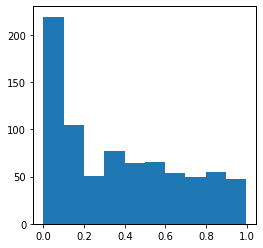

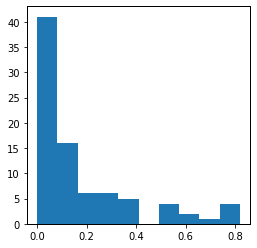

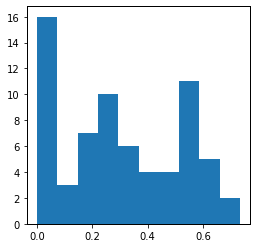

786
85
68
85
786
68
(786, 4)
(85, 4)
(68, 4)


No handles with labels found to put in legend.


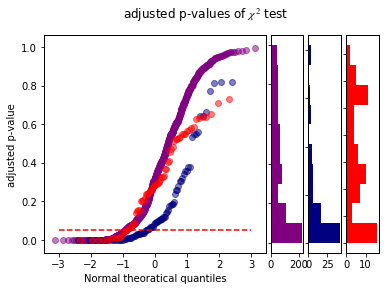

In [449]:
test_chi_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, chen_read_counts, chen_coverage_tab, chen_pca_clust.AC, 
                     psi_min = 0.2, psi_bin = 0.1, obs_min = 0.25, mrna_min = 10, read_min =10)